# notebook 3: metrics on output
_Langevin dynamics on 2d-Waddington volcano_

## imports

### mount drive

In [1]:
COLAB = False
if COLAB == True:
    drive.mount('/content/drive')

### pip installs

In [2]:
if COLAB==True:
    !pip install scanpy moscot ott-jax diffrax napari anndata -q
    !pip install "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html -q
else:
    pass 

### set save directories

In [3]:
fh_save_data = './volcano_data_saved/'
fh_save_output = './volcano_output_saved/'
fh_save_metrics = './volcano_metrics_saved/'

print(f"save data file path: {fh_save_data}")
print(f"save output file path: {fh_save_output}")
print(f"save metrics file path: {fh_save_metrics}")

save data file path: ./volcano_data_saved/
save output file path: ./volcano_output_saved/
save metrics file path: ./volcano_metrics_saved/


### imports

In [4]:
import sys
import pathlib
import os
import random
import importlib

import pandas as pd
from anndata import AnnData
import scanpy as sc
import pickle

import random
import numpy as np
from typing import Tuple
import torch

from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.cluster import KMeans
from threadpoolctl import threadpool_limits

# import plotly.graph_objects as go
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from PIL import Image

import jax
import jax.numpy as jnp
from jax import random as jax_random
import moscot as mt
import moscot.plotting as mpl
from moscot.problems.time import TemporalProblem

### import `HM-OT`

In [5]:
if COLAB == True:
    fh_hmot = "/content/drive/Othercomputers/numac/GitHub/HM-OT" # filehandle for HM-OT
    project_root = pathlib.Path(fh_hmot)
    sys.path.insert(0, fh_hmot)
    sys.path.insert(0, str(project_root / "src"))
else: 
    fh_hmot = '../../'
    project_root = pathlib.Path(fh_hmot)
    sys.path.insert(0, fh_hmot)

import src.FRLC as FRLC
import src.FRLC.FRLC_multimarginal as FRLC_multimarginal
import src.HiddenMarkovOT as HiddenMarkovOT

import src.utils.clustering as clustering
import src.utils.util_LR as util_LR
import src.utils.util_zf as util_zf

from src.utils.util_LR import convert_adata
from src.utils.waddington import visual, minima, simulation, differentiation, metrics, landscape_core_volcano, landscape_core_tristable
# TODO: minima is currently the home of function setup_point_clouds_for_waddington_ot
from src.utils.waddington import seed_everything
from src.platting import color_utils, palette_utils, string_utils, spatial_scatter, diffmap, sankey
# import src.plotting as plotting
import experiments.differentiation_map_validation as dmv # for cosine similarity


## settings: `GLOBAL_SEED`, `device`, `dtype`

### set seed

In [6]:
# Set global seed for reproducibility
GLOBAL_SEED = 42
# np.random.seed(GLOBAL_SEED)
seed = seed_everything(GLOBAL_SEED)

🌱 Setting global seed to 42
  ✓ PyTorch seeded
  ✓ JAX PRNG key created
🌱 All available RNGs seeded.


### reload / set `device`, `dtype`

In [7]:
importlib.reload(clustering)
importlib.reload(util_LR)
importlib.reload(util_zf)
importlib.reload(HiddenMarkovOT)
importlib.reload(dmv)

<module 'experiments.differentiation_map_validation' from '/Users/normandie/Documents/GitHub/HM-OT/experiments/volcano/../../experiments/differentiation_map_validation.py'>

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64

On device: cpu


## load parameters, method output

Assignment radius: 1.6
Verification (polar coords):
(-1.564, -2.709)  r= 3.13  θ= 240.0° → A240
( 3.128,  0.000)  r= 3.13  θ=   0.0° → A0
(-1.564,  2.709)  r= 3.13  θ= 120.0° → A120
(-4.799, -2.796)  r= 5.55  θ= 210.2° → B210
(-4.799,  2.796)  r= 5.55  θ= 149.8° → B150
( 4.821, -2.758)  r= 5.55  θ= 330.2° → B330
( 4.821,  2.758)  r= 5.55  θ=  29.8° → B30
(-0.022, -5.555)  r= 5.55  θ= 269.8° → B270
(-0.022,  5.555)  r= 5.55  θ=  90.2° → B90
(-7.705, -4.448)  r= 8.90  θ= 210.0° → C210
( 7.705, -4.448)  r= 8.90  θ= 330.0° → C330
( 7.705,  4.448)  r= 8.90  θ=  30.0° → C30
(-7.705,  4.448)  r= 8.90  θ= 150.0° → C150
(-0.000, -8.897)  r= 8.90  θ= 270.0° → C270
(-0.000,  8.897)  r= 8.90  θ=  90.0° → C90


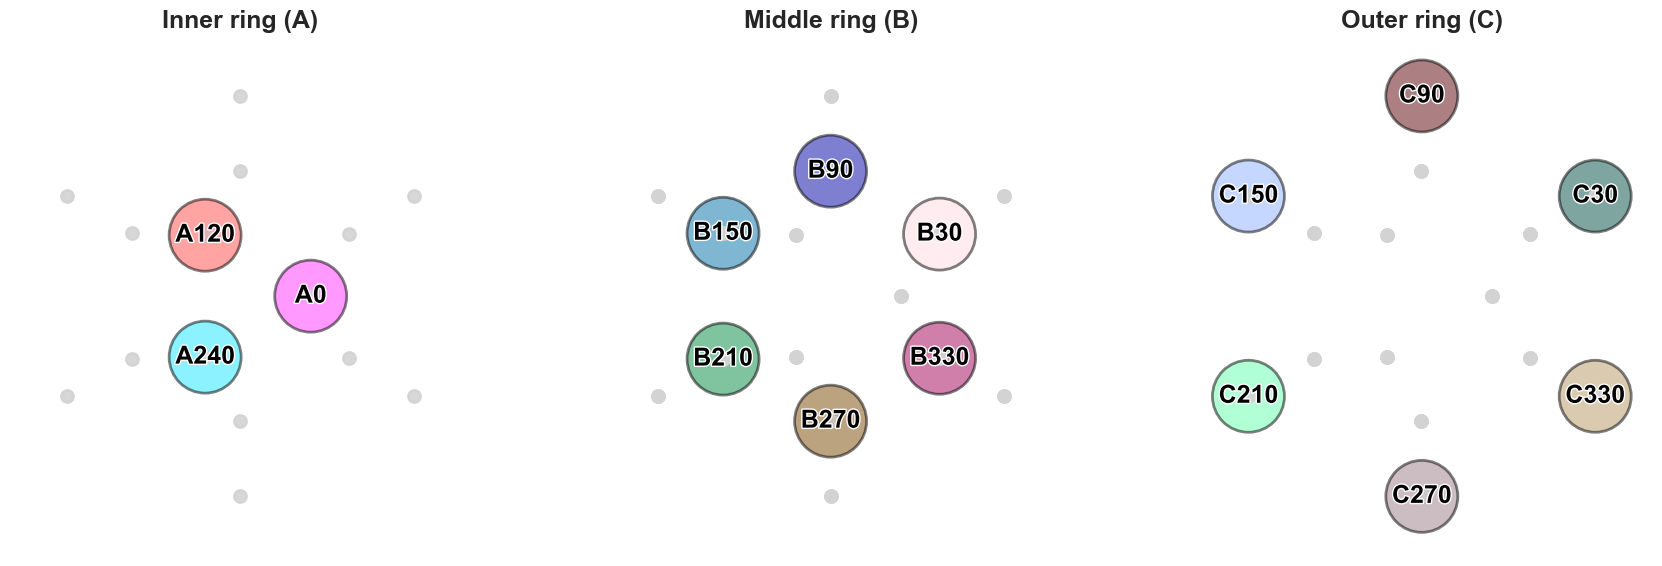


Total clusters: 15
CPU times: user 901 ms, sys: 107 ms, total: 1.01 s
Wall time: 977 ms


In [9]:
%%time

# timepoint indices of snapshots of Langevin dynamics
TIMEPOINTS = [16, 89, 3500] # snapshots taken at these timepoints

# Langevin dynamics parameteters
LANGEVIN_n_particles = 1000 # number of partciles
LANGEVIN_N_timesteps = 4000 # number of time steps
LANGEVIN_dt = 0.2
LANGEVIN_D = 0.014

# local minima of the Waddington landscape
# (+ ASSIGNMENT_RADIUS) determine cell type
MINIMA_POINTS = minima.find_local_minima()
ASSIGNMENT_RADIUS = 1.6

# Load all datasets across all noise levels
with open(fh_save_data + 'datasets.pkl', 'rb') as f:
    datasets = pickle.load(f)
    Ss = datasets[0] # Ss is the first dataset, which is the original data without noise
    f.close()

# Load ground-truth Qs and Ts with no cell types removed (1000 particles)
with open(fh_save_data + 'Ts_gt_global.pkl', 'rb') as f:
    Ts_gt_global = pickle.load(f)
    f.close()

with open(fh_save_data + 'Qs_gt_global.pkl', 'rb') as f:
    Qs_gt_global = pickle.load(f)
    f.close()

# Load ground-truth Qs and Ts after removing small cell types (915 particles)
with open(fh_save_data + 'Ts_gt_reduced.pkl', 'rb') as f:
    Ts_gt_reduced = pickle.load(f)
    f.close()

with open(fh_save_data + 'Qs_gt_reduced.pkl', 'rb') as f:
    Qs_gt_reduced = pickle.load(f)
    f.close()

# Load good rows, rank list, Xs and Ys
with open(fh_save_data + 'GOOD_ROWS.pkl', 'rb') as f:
    GOOD_ROWS = pickle.load(f)
    f.close()

with open(fh_save_data + 'RANK_LIST.pkl', 'rb') as f:
    RANK_LIST = pickle.load(f)
    f.close()

with open(fh_save_data + 'Xs.pkl', 'rb') as f:
    Xs = pickle.load(f)
    f.close()

with open(fh_save_data + 'Ys.pkl', 'rb') as f:
    Ys = pickle.load(f)
    f.close()

# construct canonical labels, colormap
STR_TO_IND_DICT_GLOBAL = { v: k \
                          for k, v in minima.IND_TO_STR_DICT_GLOBAL.items() }
_, _, _, IND_TO_COLOR_DICT_GLOBAL = palette_utils.get_diffmap_inputs(Qs_gt_global, 
                                                                     Ts_gt_global, 
                                                                     global_Qs=True)
STR_TO_COLOR_DICT_GLOBAL = {k : IND_TO_COLOR_DICT_GLOBAL[v] \
                            for k, v in STR_TO_IND_DICT_GLOBAL.items()}


CLUSTER_DICT = visual.create_cluster_dict_and_plot(
    MINIMA_POINTS,
    ASSIGNMENT_RADIUS,
    str_to_color_dict=STR_TO_COLOR_DICT_GLOBAL
)

# ─────────────────────────────────────────────────────────────────────────────────
# scatter plotting parameters

SCATTER_PAD=1.0
SCATTER_SUBPLOT_SPACING=1.0
SCATTER_FONT_SIZE=48
SCATTER_KEY_SPACING=0.25
SCATTER_DOTSIZE = 400.0
SCATTER_KEY_DOTSIZE = 1.0
LABEL_ORDER = minima.LABEL_ORDER
DOT_ALPHA = 0.8  # opacity of dots
SCATTER_OUTLINE_COLOR = "black"  # outline color for dots

canonical_order = ['U', 'A240', 'A0', 'A120', 'B210', 'B90', 'B330', 'B30', 'B270', 'B150',
                   'C210', 'C330', 'C30', 'C90', 'C270', 'C150']

# Constants for measurement noise levels
STD = 1.0
NOISE_min = 2.0 * STD
NOISE_max = 3.5 * STD
n_TIMEPOINTS = len(TIMEPOINTS)  
n_timepoints = len(TIMEPOINTS)
THRESHOLD = 20.0
n_noise_levels = 10
noise_level_range = np.linspace(NOISE_min, NOISE_max, n_noise_levels)


n_timepoints = len(TIMEPOINTS)
THRESHOLD = 20.0 # population threshold, below which we remove cell types

# ─────────────────────────────────────────────────────────────────────────────────
# diffmap plotting parameters
LINETHICK_FACTOR = 40
GLOBAL_DIFFMAP_DOTSIZE = 5.0
GLOBAL_DIFFMAP_FONTSIZE = 16
GLOBAL_DIFFMAP_STRETCH = 2.0
GLOBAL_DIFFMAP_OUTLINE = 3.0

# ─────────────────────────────────────────────────────────────────────────────────
# ─────────────────────────────────────────────────────────────────────────────────
# ─────────────────────────────────────────────────────────────────────────────────
# NOTE: LOAD METHOD OUTPUTS FROM NOTEBOOK 2
with open(fh_save_output + 'hmot_Qs_list.pkl', 'rb') as f:
    hmot_Qs_list = pickle.load(f)
    f.close()

with open(fh_save_output + 'hmot_Ts_list.pkl', 'rb') as f:
    hmot_Ts_list = pickle.load(f)
    f.close()

with open(fh_save_output + 'km_Qs_list.pkl', 'rb') as f:
    km_Qs_list = pickle.load(f)
    f.close()

with open(fh_save_output + 'wot_Ts_list.pkl', 'rb') as f:
    wot_Ts_list = pickle.load(f)
    f.close()

with open(fh_save_output + 'gwot_Ts_list.pkl', 'rb') as f:
    gwot_Ts_list = pickle.load(f)
    f.close()

## params, reduced diffmap 

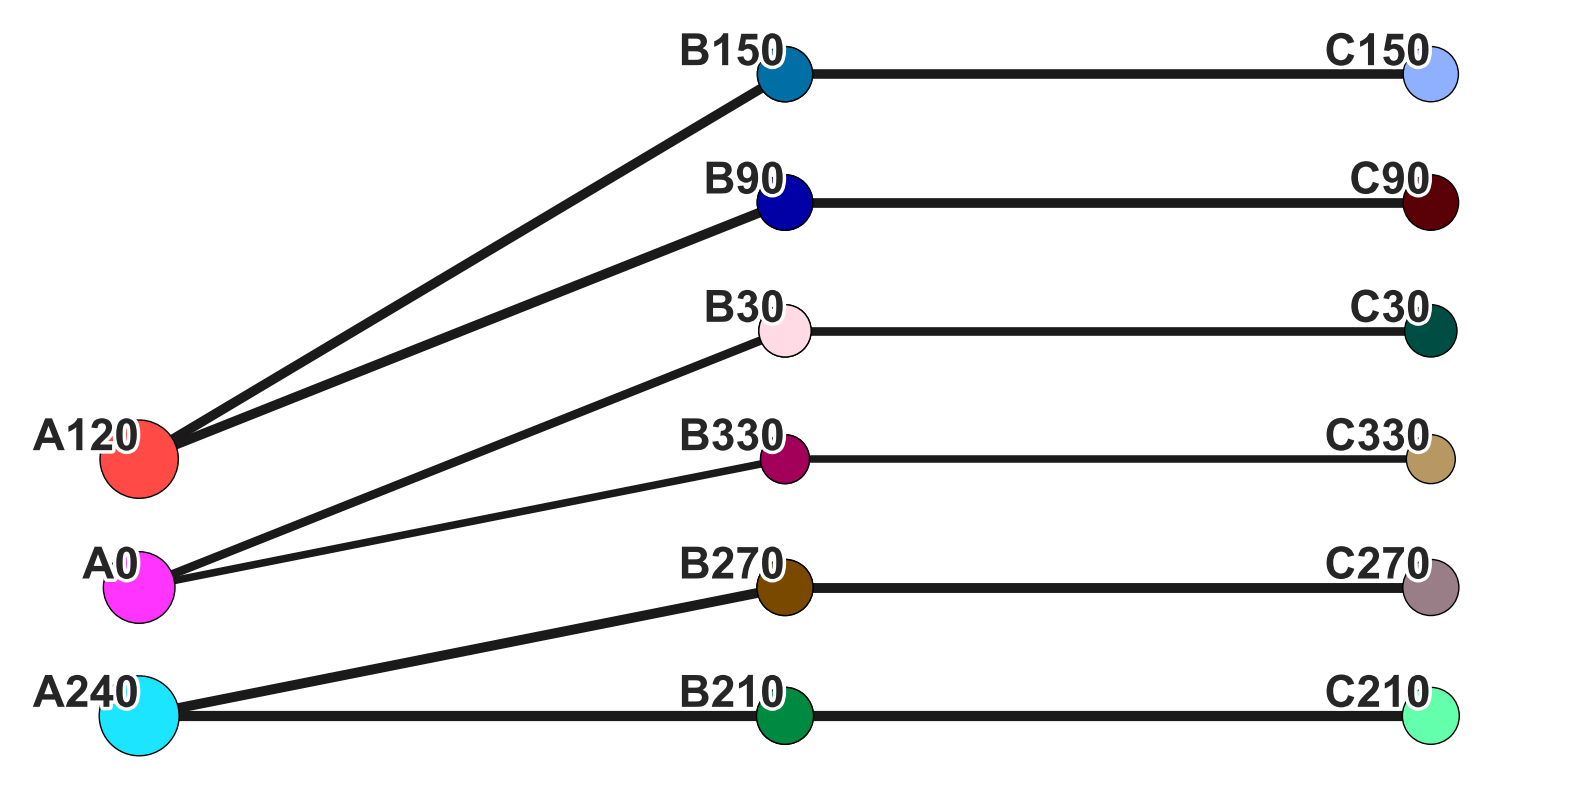

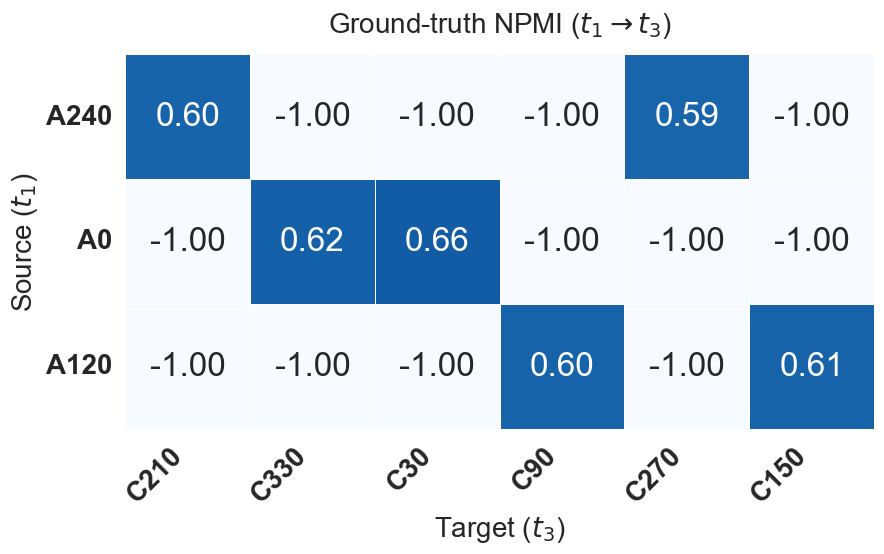

In [10]:
LINETHICK_FACTOR = 40
GLOBAL_DIFFMAP_DOTSIZE = 5.0
GLOBAL_DIFFMAP_FONTSIZE = 16
GLOBAL_DIFFMAP_STRETCH = 2.0
GLOBAL_DIFFMAP_OUTLINE = 3.0

'''def NPMI_t1_to_t3_matrix(Qs, Ts, labels_Q):
    """
    Compute full matrix of NPMI scores between clusters at timepoint 1 and timepoint 3

    Args:
        Qs: List of soft assignment matrices [Q0, Q1, Q2]
        Ts: List of transition matrices [T01, T12]
        labels_Q: List of string label lists for each timepoint [labels0, labels1, labels2]

    Returns:
        DataFrame with columns ['source', 'target', 'npmi'] for all (t1, t3) cluster pairs.
    """
    Q0, Q1, Q2 = Qs
    T01, T12 = Ts
    labels0, labels1, labels2 = labels_Q

    # Compute composite transition T02 = T01 @ T12
    g0 = np.sum(Q0, axis=0)
    g1 = np.sum(Q1, axis=0)
    g2 = np.sum(Q2, axis=0)

    T02 = T01 @ np.diag(1/g1) @ T12

    total_mass0 = g0.sum()
    total_mass2 = g2.sum()

    npmi_scores = []
    for i_row, src_label in enumerate(labels0):
        for j_col, tgt_label in enumerate(labels2):
            p_joint = T02[i_row, j_col]
            if p_joint > 0:
                p_x = g0[i_row] / total_mass0
                p_y = g2[j_col] / total_mass2
                npmi = dmv.NPMI(p_joint, p_x, p_y)
                npmi_scores.append((src_label, tgt_label, npmi))

    df = pd.DataFrame(npmi_scores, columns=["source", "target", "npmi"])
    return df'''
def NPMI_t1_to_t3_matrix(Qs, Ts, labels_Q, fill_nan=-1.0, check=True):
    """
    Full NPMI matrix between clusters at t1 and t3.

    Parameters
    ----------
    Qs : [Q0, Q1, Q2]
    Ts : [T01, T12]
    labels_Q : [labels0, labels1, labels2]
    fill_nan : value to use when Pxy == 0
    check : run sanity assertions

    Returns
    -------
    DataFrame with ['source', 'target', 'npmi'].
    """
    Q0, Q1, Q2      = Qs
    T01, T12        = Ts
    labels0, _, labels2 = labels_Q

    # masses
    g0 = Q0.sum(axis=0)
    g1 = Q1.sum(axis=0)

    # composite transition
    T02 = T01 @ np.diag(1.0 / g1) @ T12   # as in your code

    # treat T02 as joint, normalize and derive marginals from it
    Pxy = np.maximum(T02, 0)
    S = Pxy.sum()
    if S == 0:
        raise ValueError("T02 has zero total mass.")
    Pxy /= S
    Px = Pxy.sum(axis=1, keepdims=True)
    Py = Pxy.sum(axis=0, keepdims=True)

    with np.errstate(divide='ignore', invalid='ignore'):
        PMI  = np.log(Pxy) - np.log(Px) - np.log(Py)
        NPMI = PMI / (-np.log(Pxy))
    NPMI[~np.isfinite(NPMI)] = fill_nan

    if check:
        assert np.isclose(Pxy.sum(), 1.0)
        assert np.all(Pxy >= -1e-12)
        assert np.all(NPMI <= 1 + 1e-8)

    rows = [
        (labels0[i], labels2[j], float(NPMI[i, j]))
        for i in range(len(labels0))
        for j in range(len(labels2))
    ]
    return pd.DataFrame(rows, columns=["source", "target", "npmi"])

NPMI_VALLEYS_LIST = [
    ['A240', 'A0', 'A120'],  # time-point 1
    ['B210', 'B90', 'B330', 'B30', 'B270', 'B150'],  # time-point 2
    ['C210', 'C330', 'C30', 'C90', 'C270', 'C150'],  # time-point 3
]


LINETHICK_FACTOR = 40
DIFFMAP_DOTSIZE = 20.0
DIFFMAP_FONTSIZE = 32
DIFFMAP_STRETCH = 2.0
DIFFMAP_OUTLINE = 5.0



# Ground-truth diffmap, with small cell types filtered out
diffmap.diffmap_from_QT([Q * LANGEVIN_n_particles for Q in Qs_gt_reduced], 
                        Ts_gt_reduced, 
                        global_Qs=False,
                        ind_to_str_dict = minima.IND_TO_STR_DICT_EXP,
                        str_to_color_dict = STR_TO_COLOR_DICT_GLOBAL,
                        linethick_factor=LINETHICK_FACTOR,
                        dotsize=0.5 * DIFFMAP_DOTSIZE,
                        stretch=DIFFMAP_STRETCH,
                        fontsize=DIFFMAP_FONTSIZE,
                        outline=DIFFMAP_OUTLINE,
                        label_order=minima.LABEL_ORDER)

FONTSIZE = 20
cmap = "Blues"

# ── Build the matrix exactly as before ───────────────────────────────────────
canonical_order = [
    "A240", "A0", "A120", "B210", "B90", "B330", "B30", "B270", "B150",
    "C210", "C330", "C30", "C90", "C270", "C150",
]
gt_NPMI_df = NPMI_t1_to_t3_matrix(Qs_gt_reduced, Ts_gt_reduced, NPMI_VALLEYS_LIST)
gt_npmi_matrix_ = gt_NPMI_df.pivot(index="source", columns="target", values="npmi")

row_labels = [l for l in canonical_order if l in NPMI_VALLEYS_LIST[0]]
col_labels = [l for l in canonical_order if l in NPMI_VALLEYS_LIST[2]]
gt_npmi_matrix = (
    gt_npmi_matrix_.reindex(index=row_labels, columns=col_labels)
    .fillna(-1)
)

vmin, vmax = -1.0, 1.0

# ── Single-axes plot ────────────────────────────────────────────────────────
sns.set_theme(style="white", context="notebook")

fig, ax = plt.subplots(figsize=(9, 9))

# NPMI heatmap
sns.heatmap(
    gt_npmi_matrix,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    linewidths=0.5,
    linecolor="white",
    square=True,
    ax=ax,
    cbar=False,
    annot_kws={"size": 24},
)

ax.set_title(
    rf"Ground-truth NPMI ($t_1 \rightarrow t_3$)",
    fontsize=FONTSIZE,
    pad=16,
)
ax.set_xlabel("Target ($t_3$)", fontsize= FONTSIZE)
ax.set_ylabel("Source ($t_1$)", fontsize= FONTSIZE)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=FONTSIZE, weight="bold")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=FONTSIZE, weight="bold")

plt.tight_layout()
plt.show()

## metric computation loop

In [11]:
%%time
SHOW_PLOTS = False # set to True to visualize the outputs
# retaining hyperparameters used for reference
ITER = 100
GAMMA = 120.0
ALPHA = 0.0
TAU_IN = 1e5

ALLOWED_VALLEYS_LIST = [
    ['A240', 'A0', 'A120'],  # time-point 1
    ['B210', 'B150', 'B330', 'B90', 'B30', 'B270'],  # time-point 2
    ['C210', 'C330', 'C30', 'C150', 'C270', 'C90'],  # time-point 3
]

STR_TO_VALLEY_DICT = { 
    v : k for k, v in CLUSTER_DICT.items()
}

def get_barycenters(Q, S):
    Q_col_stochastic = Q @ np.diag(1 / Q.sum(axis=0))
    barycenters = Q_col_stochastic.T @ S
    return barycenters

def centroid_cossim(Qs_gt,
                    Qs_pred, 
                    Ts_pred, 
                    Ss): # no passing of noisy data for now
    
    X1, X2, X3 = Ss 
    Q1, Q2, Q3 = Qs_gt
    C1, C3 = get_barycenters(Q1, X1), get_barycenters(Q3, X3)

    Q1_p, Q2_p, Q3_p = Qs_pred
    C2_p = get_barycenters(Q2_p, X2)

    # Transition matrices
    T12_pred, T23_pred = Ts_pred

    # Predicted centroids through the differentiation map T
    C1_pred = np.diag(1 / np.sum(T12_pred, axis=1)) @ T12_pred @ C2_p
    t1_sim_pred = cosine_similarity(C1, C1_pred)

    C3_pred = np.diag(1 / np.sum(T23_pred, axis=0)) @ T23_pred.T @ C2_p
    t3_sim_pred = cosine_similarity(C3, C3_pred)
    return [t1_sim_pred, t3_sim_pred]

# ────────────────────────────────────────────────────────────────────────────────
# initialize AMI, ARI lists
hmot_ami_list, hmot_ari_list, km_ami_list, km_ari_list = [], [], [], []
# initialize cossim_lists
hmot_cossim_list, wot_cossim_list, gwot_cossim_list = [], [], []
# initialize barycenter lists for HM-OT and $k$-means

# NOTE: we always use barycenters computed from noisy data,\
#  but the others are recorded for reference
hmot_bary_list, hmot_noisy_bary_list = [], []
km_bary_list, km_noisy_bary_list = [], []
gwot_bary_list, gwot_noisy_bary_list = [], []

# Frobenius norm of T12 matrices to ground-truth T12 matrix
hmot_Frob_12_list, wot_Frob_12_list, gwot_Frob_12_list = [], [], []
# Frobenius norm of T23 matrices to ground-truth T23 matrix
hmot_Frob_23_list, wot_Frob_23_list, gwot_Frob_23_list = [], [], []


for i, level in enumerate(noise_level_range):
    torch.manual_seed(GLOBAL_SEED)
    print(f'noise level {i+1} / {len(noise_level_range)}: {level}')
    Ss_noisy = datasets[i+1]
    # ────────────────────────────────────────────────────────────────────────────────
    # ────────────────────────────────────────────────────────────────────────────────
    # Load all results for this noise level
    # ────────────────────────────────────────────────────────────────────────────────
    # load k-means results
    Qs_reg_km = km_Qs_list[i]

    # compute k-means barycenters
    km_bary = [ get_barycenters(Q, S) for Q, S in zip(Qs_reg_km, Ss) ]
    km_noisy_bary = [ get_barycenters(Q, S) for Q, S in zip(Qs_reg_km, Ss_noisy) ]

    # Append results to lists
    km_bary_list.append(km_bary)
    km_noisy_bary_list.append(km_noisy_bary)

    # ────────────────────────────────────────────────────────────────────────────────
    # load HM-OT results
    Qs_reg_hmot = hmot_Qs_list[i]
    Ts_reg_hmot = hmot_Ts_list[i]

    # compute HM-OT barycenters
    hmot_bary = [ get_barycenters(Q, S) for Q, S in zip(Qs_reg_hmot, Ss) ]
    hmot_noisy_bary = [ get_barycenters(Q, S) for Q, S in zip(Qs_reg_hmot, Ss_noisy) ]

    # append HM-OT barycenter results to lists
    hmot_bary_list.append(hmot_bary)
    hmot_noisy_bary_list.append(hmot_noisy_bary)

    # ────────────────────────────────────────────────────────────────────────────────
    # load W-OT results
    # NOTE: W-OT was used with k-means: these matrices are k-means coarsenings of W-OT plans
    Ts_reg_wot = wot_Ts_list[i]
    Ts_reg_gwot = gwot_Ts_list[i]

    # ────────────────────────────────────────────────────────────────────────────────
    # ────────────────────────────────────────────────────────────────────────────────
    # Optionally plot the loaded outputs
    # ────────────────────────────────────────────────────────────────────────────────
    if SHOW_PLOTS:
        # ────────────────────────────────────────────────────────────────────────────────
        # visualize k-means clusters
        print(f"$k$-means clusters for noise level = {level}")
        spatial_scatter.plot_clusters_from_QT(
            Qs = Qs_reg_km,
            Ts = [None, None],
            Ss=Ss_noisy,
            ind_to_str_dict = minima.IND_TO_STR_DICT_EXP,
            str_to_color_dict = STR_TO_COLOR_DICT_GLOBAL,
            dotsize=SCATTER_DOTSIZE,
            key_dotsize=SCATTER_KEY_DOTSIZE,
            fontsize=SCATTER_FONT_SIZE,
            pad=SCATTER_PAD,
            subplot_spacing=SCATTER_SUBPLOT_SPACING,
            key_spacing=SCATTER_KEY_SPACING,
            global_Qs=False,
            label_order=LABEL_ORDER,
            outline_color=SCATTER_OUTLINE_COLOR,
            dot_alpha=DOT_ALPHA)
        # ────────────────────────────────────────────────────────────────────────────────
        # plot HM-OT clusters
        print(f"plotting HM-OT clusters for noise level = {level}")
        spatial_scatter.plot_clusters_from_QT(
            Qs = Qs_reg_hmot,
            Ts = Ts_reg_hmot,
            Ss=Ss_noisy,
            ind_to_str_dict = minima.IND_TO_STR_DICT_EXP,
            str_to_color_dict = STR_TO_COLOR_DICT_GLOBAL,
            dotsize=SCATTER_DOTSIZE,
            key_dotsize=SCATTER_KEY_DOTSIZE,
            fontsize=SCATTER_FONT_SIZE,
            pad=SCATTER_PAD,
            subplot_spacing=SCATTER_SUBPLOT_SPACING,
            key_spacing=SCATTER_KEY_SPACING,
            global_Qs=False,
            label_order=LABEL_ORDER,
            outline_color=SCATTER_OUTLINE_COLOR,
            dot_alpha=DOT_ALPHA)
        # ────────────────────────────────────────────────────────────────────────────────
        # plot HM-OT diffmap
        print(f"plotting HM-OT diffmap for noise level = {level}")
        diffmap.diffmap_from_QT([Q * LANGEVIN_n_particles for Q in Qs_reg_hmot], 
                                Ts_reg_hmot, 
                                global_Qs=False,
                                ind_to_str_dict = minima.IND_TO_STR_DICT_EXP,
                                str_to_color_dict = STR_TO_COLOR_DICT_GLOBAL,
                                linethick_factor=LINETHICK_FACTOR,
                                dotsize=0.5 * DIFFMAP_DOTSIZE,
                                stretch=DIFFMAP_STRETCH,
                                fontsize=DIFFMAP_FONTSIZE,
                                outline=DIFFMAP_OUTLINE,
                                label_order=LABEL_ORDER)      
        # ────────────────────────────────────────────────────────────────────────────────
        # plot W-OT diffmap
        print(f"plotting (W-OT + $k$-means) diffmap for noise level = {level}")
        diffmap.diffmap_from_QT(Qs_reg_km, 
                                Ts_reg_wot, 
                                global_Qs=False,
                                ind_to_str_dict=minima.IND_TO_STR_DICT_EXP,
                                str_to_color_dict=STR_TO_COLOR_DICT_GLOBAL,
                                dotsize=0.5 *DIFFMAP_DOTSIZE,
                                linethick_factor=LINETHICK_FACTOR,
                                stretch=DIFFMAP_STRETCH,
                                fontsize=DIFFMAP_FONTSIZE,
                                outline=DIFFMAP_OUTLINE,
                                label_order=LABEL_ORDER)
    # ────────────────────────────────────────────────────────────────────────────────
    # ────────────────────────────────────────────────────────────────────────────────
    # Compute metrics
    # ────────────────────────────────────────────────────────────────────────────────
    # compute ARI, AMI
    hmot_ami, hmot_ari = metrics.compute_clustering_metrics(Qs_gt_reduced, [Q[GOOD_ROWS,:] for Q in Qs_reg_hmot])
    hmot_ami_list.append(hmot_ami)
    hmot_ari_list.append(hmot_ari)

    km_ami, km_ari = metrics.compute_clustering_metrics(Qs_gt_reduced, [Q[GOOD_ROWS,:] for Q in Qs_reg_km])
    km_ami_list.append(km_ami)
    km_ari_list.append(km_ari)
    # ────────────────────────────────────────────────────────────────────────────────
    # compute frobenius distances to ground-truth
    # for HM-OT
    hmot_Frob_12 = np.linalg.norm(Ts_reg_hmot[0] - Ts_gt_reduced[0], ord='fro')
    hmot_Frob_23 = np.linalg.norm(Ts_reg_hmot[1] - Ts_gt_reduced[1], ord='fro')
    hmot_Frob_12_list.append(hmot_Frob_12)
    hmot_Frob_23_list.append(hmot_Frob_23)
    # for W-OT
    wot_Frob_12 = np.linalg.norm(Ts_reg_wot[0] - Ts_gt_reduced[0], ord='fro')
    wot_Frob_23 = np.linalg.norm(Ts_reg_wot[1] - Ts_gt_reduced[1], ord='fro')
    wot_Frob_12_list.append(wot_Frob_12)
    wot_Frob_23_list.append(wot_Frob_23)
    # for gWOT 
    gwot_Frob_12 = np.linalg.norm(Ts_reg_gwot[0] - Ts_gt_reduced[0], ord='fro')
    gwot_Frob_23 = np.linalg.norm(Ts_reg_gwot[1] - Ts_gt_reduced[1], ord='fro')
    gwot_Frob_12_list.append(gwot_Frob_12)
    gwot_Frob_23_list.append(gwot_Frob_23)
    # ────────────────────────────────────────────────────────────────────────────────
    # compute centroid cosine similarities
    hmot_cossim = centroid_cossim(Qs_gt_reduced, [Q[GOOD_ROWS,:] for Q in Qs_reg_hmot], Ts_reg_hmot, [S[GOOD_ROWS,:] for S in Ss_noisy])
    wot_cossim = centroid_cossim(Qs_gt_reduced, [Q[GOOD_ROWS,:] for Q in Qs_reg_km], Ts_reg_wot, [S[GOOD_ROWS,:] for S in Ss_noisy])
    gwot_cossim = centroid_cossim(Qs_gt_reduced, [Q[GOOD_ROWS,:] for Q in Qs_reg_km], Ts_reg_gwot, [S[GOOD_ROWS,:] for S in Ss_noisy])
    hmot_cossim_list.append(hmot_cossim)
    wot_cossim_list.append(wot_cossim)
    gwot_cossim_list.append(gwot_cossim)



noise level 1 / 10: 2.0
t=0    AMI=1.0000  ARI=1.0000  N=  915  clusters(true/pred)=3/3
t=1    AMI=0.5645  ARI=0.5037  N=  915  clusters(true/pred)=6/6
t=2    AMI=0.9052  ARI=0.9186  N=  915  clusters(true/pred)=6/6
t=0    AMI=1.0000  ARI=1.0000  N=  915  clusters(true/pred)=3/3
t=1    AMI=0.6970  ARI=0.6722  N=  915  clusters(true/pred)=6/6
t=2    AMI=0.9052  ARI=0.9186  N=  915  clusters(true/pred)=6/6
noise level 2 / 10: 2.1666666666666665
t=0    AMI=0.4770  ARI=0.5512  N=  915  clusters(true/pred)=3/3
t=1    AMI=0.5144  ARI=0.4224  N=  915  clusters(true/pred)=6/6
t=2    AMI=0.8777  ARI=0.8947  N=  915  clusters(true/pred)=6/6
t=0    AMI=0.4770  ARI=0.5512  N=  915  clusters(true/pred)=3/3
t=1    AMI=0.6101  ARI=0.5590  N=  915  clusters(true/pred)=6/6
t=2    AMI=0.8777  ARI=0.8947  N=  915  clusters(true/pred)=6/6
noise level 3 / 10: 2.3333333333333335
t=0    AMI=0.3871  ARI=0.4550  N=  915  clusters(true/pred)=3/3
t=1    AMI=0.5006  ARI=0.4175  N=  915  clusters(true/pred)=6/6
t=

## plotting params

In [32]:
LEGEND_FONTSIZE = 20

## AMI / ARI plots

In [33]:
hmot_ami_np = np.array(hmot_ami_list)
hmot_ari_np = np.array(hmot_ari_list)
km_ami_np = np.array(km_ami_list)
km_ari_np = np.array(km_ari_list)

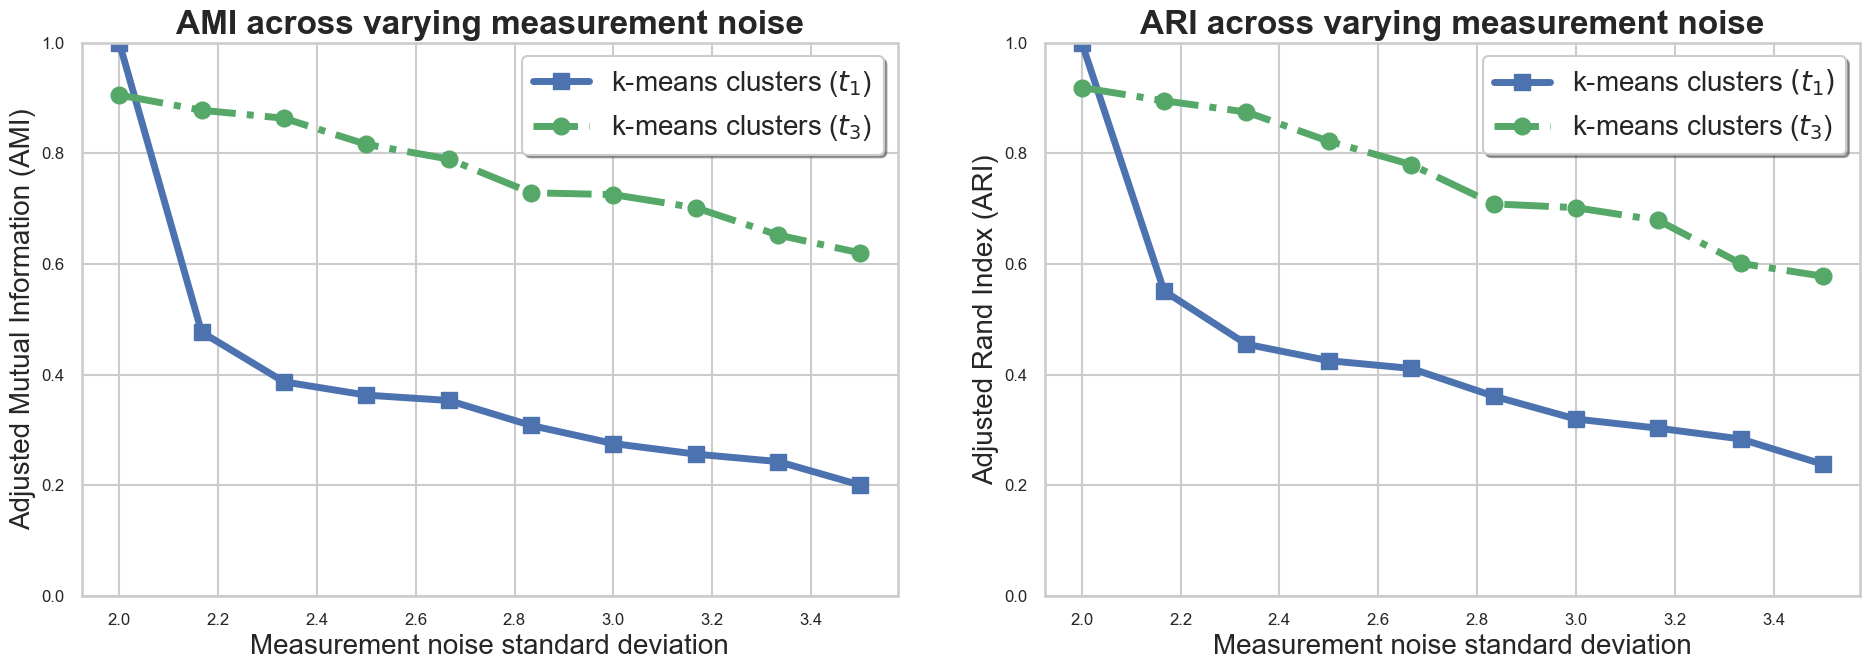

In [41]:
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.0)

# Create 1x2 subplot layout
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: AMI for both time points
axes[0].plot(noise_level_range,
             km_ami_np.T[0, :],
             'b-',
             linewidth=5,
             label='k-means clusters ($t_1$)',
             marker='s',
             markersize=12,
             alpha=1.0)

axes[0].plot(noise_level_range,
             km_ami_np.T[2, :],
             'g-.',
             linewidth=5,
             label='k-means clusters ($t_3$)',
             marker='o',
             markersize=12,
             alpha=1.0)

axes[0].set_xlabel('Measurement noise standard deviation', fontsize=20)
axes[0].set_ylabel('Adjusted Mutual Information (AMI)', fontsize=20)
axes[0].set_title('AMI across varying measurement noise', fontsize=24, fontweight='bold')
axes[0].legend(fontsize=LEGEND_FONTSIZE, frameon=True, fancybox=True, shadow=True)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].set_ylim(0, 1)

# Plot 2: ARI for both time points
axes[1].plot(noise_level_range,
             km_ari_np.T[0, :],
             'b-',
             linewidth=5,
             label='k-means clusters $(t_1)$',
             marker='s',
             markersize=12,
             alpha=1.0)

axes[1].plot(noise_level_range,
             km_ari_np.T[2, :],
             'g-.',
             linewidth=5,
             label='k-means clusters ($t_3$)',
             marker='o',
             markersize=12,
             alpha=1.0)

axes[1].set_xlabel('Measurement noise standard deviation', fontsize=20)
axes[1].set_ylabel('Adjusted Rand Index (ARI)', fontsize=20)
axes[1].set_title('ARI across varying measurement noise', fontsize=24, fontweight='bold')
axes[1].legend(fontsize=LEGEND_FONTSIZE, frameon=True, fancybox=True, shadow=True)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].set_ylim(0, 1)

# Adjust spacing between subplots
plt.tight_layout(pad=3.0)
plt.show()

In [43]:
hmot_ami_np

array([[1.        , 0.56454363, 0.90518333],
       [0.47695605, 0.51440339, 0.87773102],
       [0.38707902, 0.50057004, 0.86326713],
       [0.36304812, 0.46086762, 0.81599069],
       [0.35338506, 0.42640281, 0.78960494],
       [0.30825675, 0.40847059, 0.72862707],
       [0.2755316 , 0.38442827, 0.72521921],
       [0.25647769, 0.36256736, 0.70154567],
       [0.2430234 , 0.33478483, 0.65228152],
       [0.2004603 , 0.32920557, 0.61980359]])

In [44]:
hmot_ari_np 

array([[1.        , 0.50369048, 0.91861565],
       [0.55120668, 0.42244032, 0.89467503],
       [0.45504982, 0.41746767, 0.87451482],
       [0.42521929, 0.38508583, 0.82159691],
       [0.4112501 , 0.33897499, 0.77964195],
       [0.36127814, 0.32849701, 0.70855792],
       [0.31983581, 0.30425344, 0.70167686],
       [0.30328098, 0.27643393, 0.67871595],
       [0.2839072 , 0.27091643, 0.60102603],
       [0.23807484, 0.25484687, 0.57789533]])

In [45]:
km_ami_np

array([[1.        , 0.69695763, 0.90518333],
       [0.47695605, 0.61005832, 0.87773102],
       [0.38707902, 0.55746518, 0.86326713],
       [0.36304812, 0.54627011, 0.81599069],
       [0.35338506, 0.45528988, 0.78960494],
       [0.30825675, 0.41373932, 0.72862707],
       [0.2755316 , 0.41122445, 0.72521921],
       [0.25647769, 0.41741002, 0.70154567],
       [0.2430234 , 0.34403916, 0.65228152],
       [0.2004603 , 0.34940681, 0.61980359]])

In [46]:
km_ari_np

array([[1.        , 0.67217226, 0.91861565],
       [0.55120668, 0.55904391, 0.89467503],
       [0.45504982, 0.47388986, 0.87451482],
       [0.42521929, 0.48977966, 0.82159691],
       [0.4112501 , 0.32853321, 0.77964195],
       [0.36127814, 0.3077609 , 0.70855792],
       [0.31983581, 0.30539804, 0.70167686],
       [0.30328098, 0.3287732 , 0.67871595],
       [0.2839072 , 0.25202617, 0.60102603],
       [0.23807484, 0.24310337, 0.57789533]])

### AMI, ARI at middle timepoint $t=2$ (`HM-OT` and $k$-means differ here)

#### AMI, $t=2$

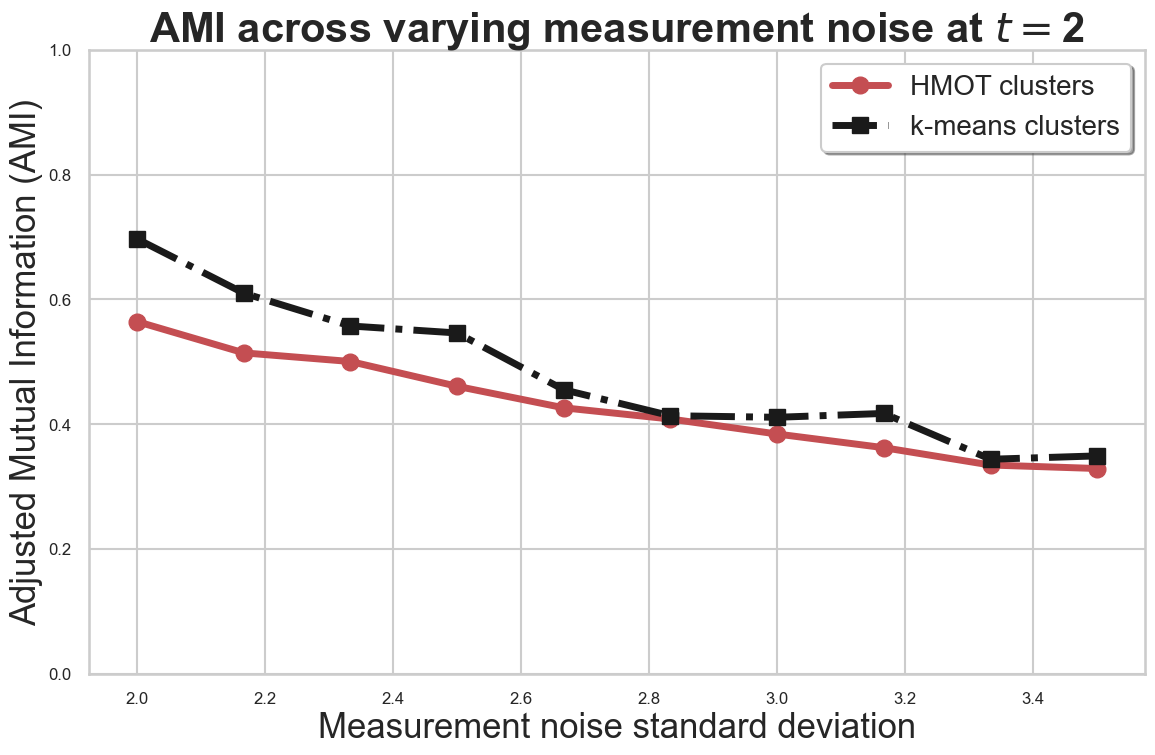

In [42]:
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

tp = 1
plt.figure(figsize=(12, 8))

plt.plot(noise_level_range,
         hmot_ami_np.T[tp, :],
         'r-',
         linewidth=5,
         label='HMOT clusters',
         marker='o',
         markersize=12,
         alpha=1.0)

plt.plot(noise_level_range,
         km_ami_np.T[tp, :],
         'k-.',
         linewidth=5,
         label='k-means clusters',
         marker='s',
         markersize=12,
         alpha=1.0)

plt.xlabel(f'Measurement noise standard deviation', fontsize=25)
plt.ylabel('Adjusted Mutual Information (AMI)', fontsize=25)
plt.title(f'AMI across varying measurement noise at $t=${tp+1}', fontsize=30, fontweight='bold')

plt.legend(fontsize=20, frameon=True, fancybox=True, shadow=True)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

#### ARI, $t=2$

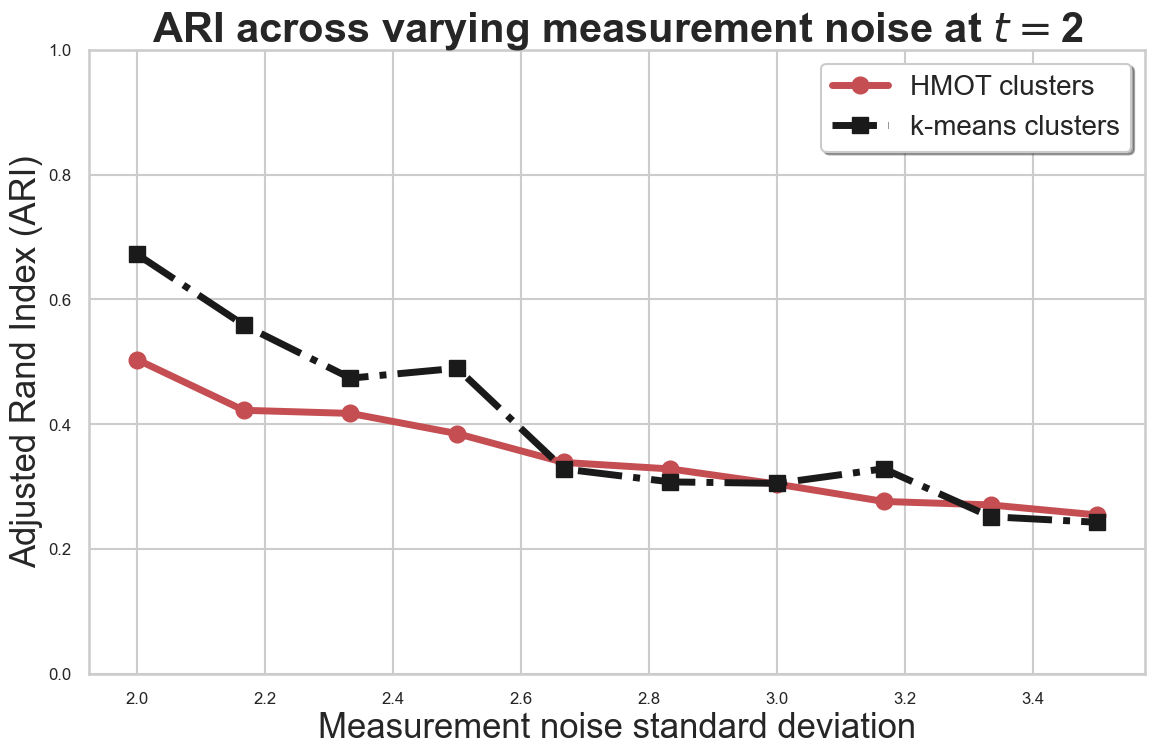

In [18]:
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

tp = 1
plt.figure(figsize=(12, 8))

plt.plot(noise_level_range,
         hmot_ari_np.T[tp, :],
         'r-',
         linewidth=5,
         label='HMOT clusters',
         marker='o',
         markersize=12,
         alpha=1.0)

plt.plot(noise_level_range,
         km_ari_np.T[tp, :],
         'k-.',
         linewidth=5,
         label='k-means clusters',
         marker='s',
         markersize=12,
         alpha=1.0)

plt.xlabel(f'Measurement noise standard deviation', fontsize=25)
plt.ylabel('Adjusted Rand Index (ARI)', fontsize=25)
plt.title(f'ARI across varying measurement noise at $t=${tp+1}', fontsize=30, fontweight='bold')

plt.legend(fontsize=20, frameon=True, fancybox=True, shadow=True)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

## NPMI plots

### NPMI plots

noise level 1 / 10: 2.0
noise level 2 / 10: 2.1666666666666665
noise level 3 / 10: 2.3333333333333335
noise level 4 / 10: 2.5
noise level 5 / 10: 2.6666666666666665
noise level 6 / 10: 2.833333333333333
noise level 7 / 10: 3.0
noise level 8 / 10: 3.1666666666666665
noise level 9 / 10: 3.333333333333333
noise level 10 / 10: 3.5
noise level 2.0


/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_75470/1370114835.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


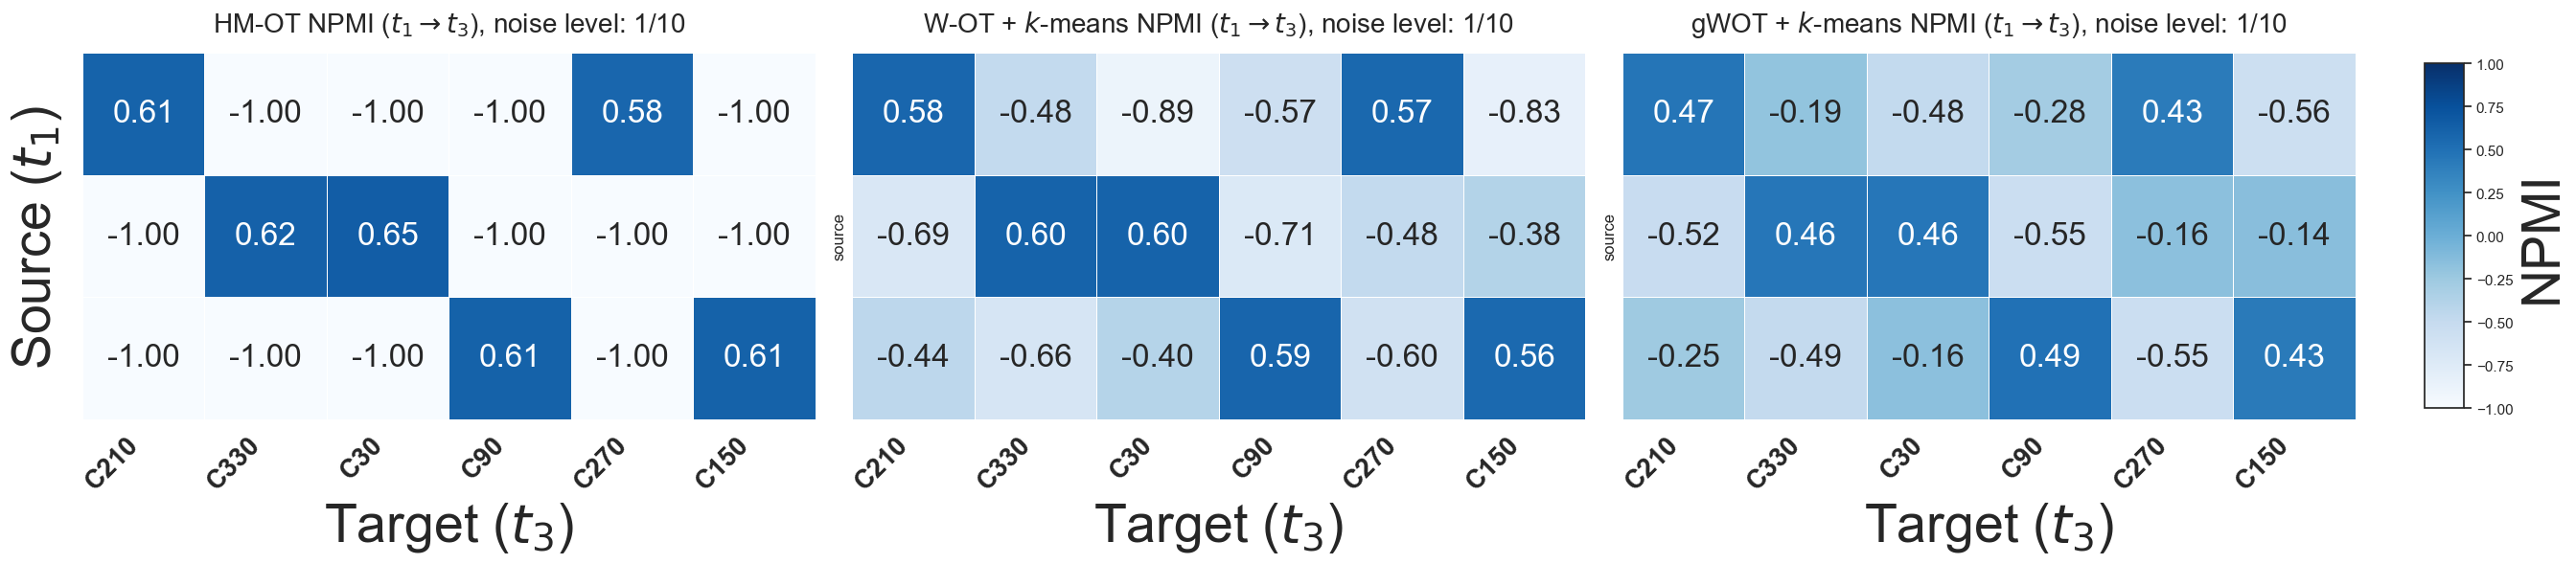

noise level 2.1666666666666665


/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_75470/1370114835.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


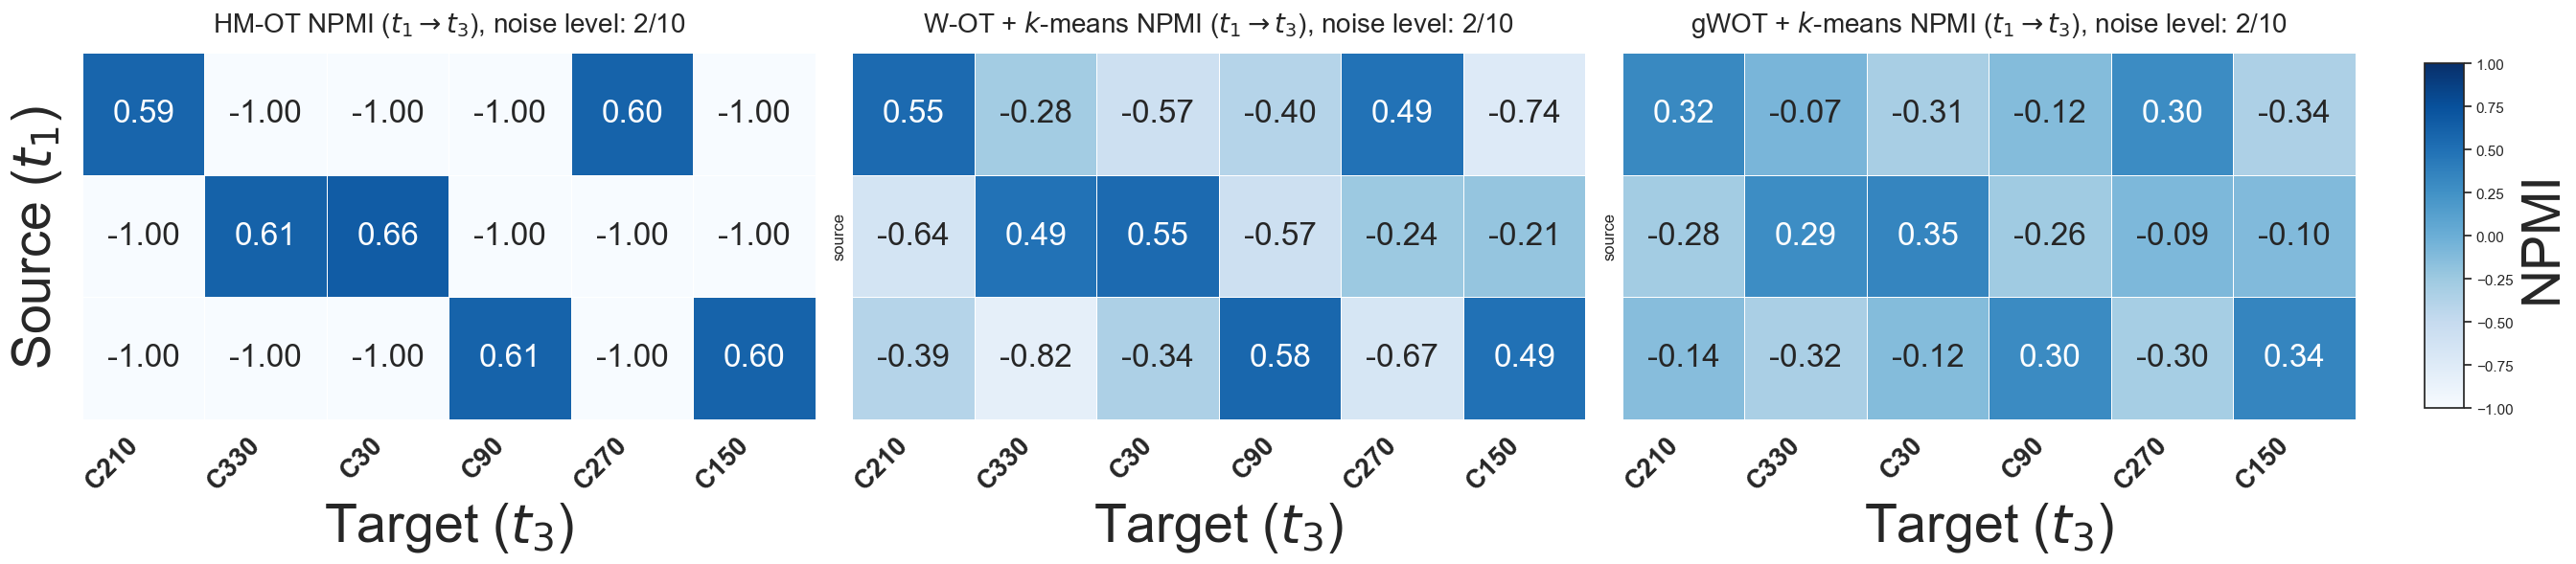

noise level 2.3333333333333335


/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_75470/1370114835.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


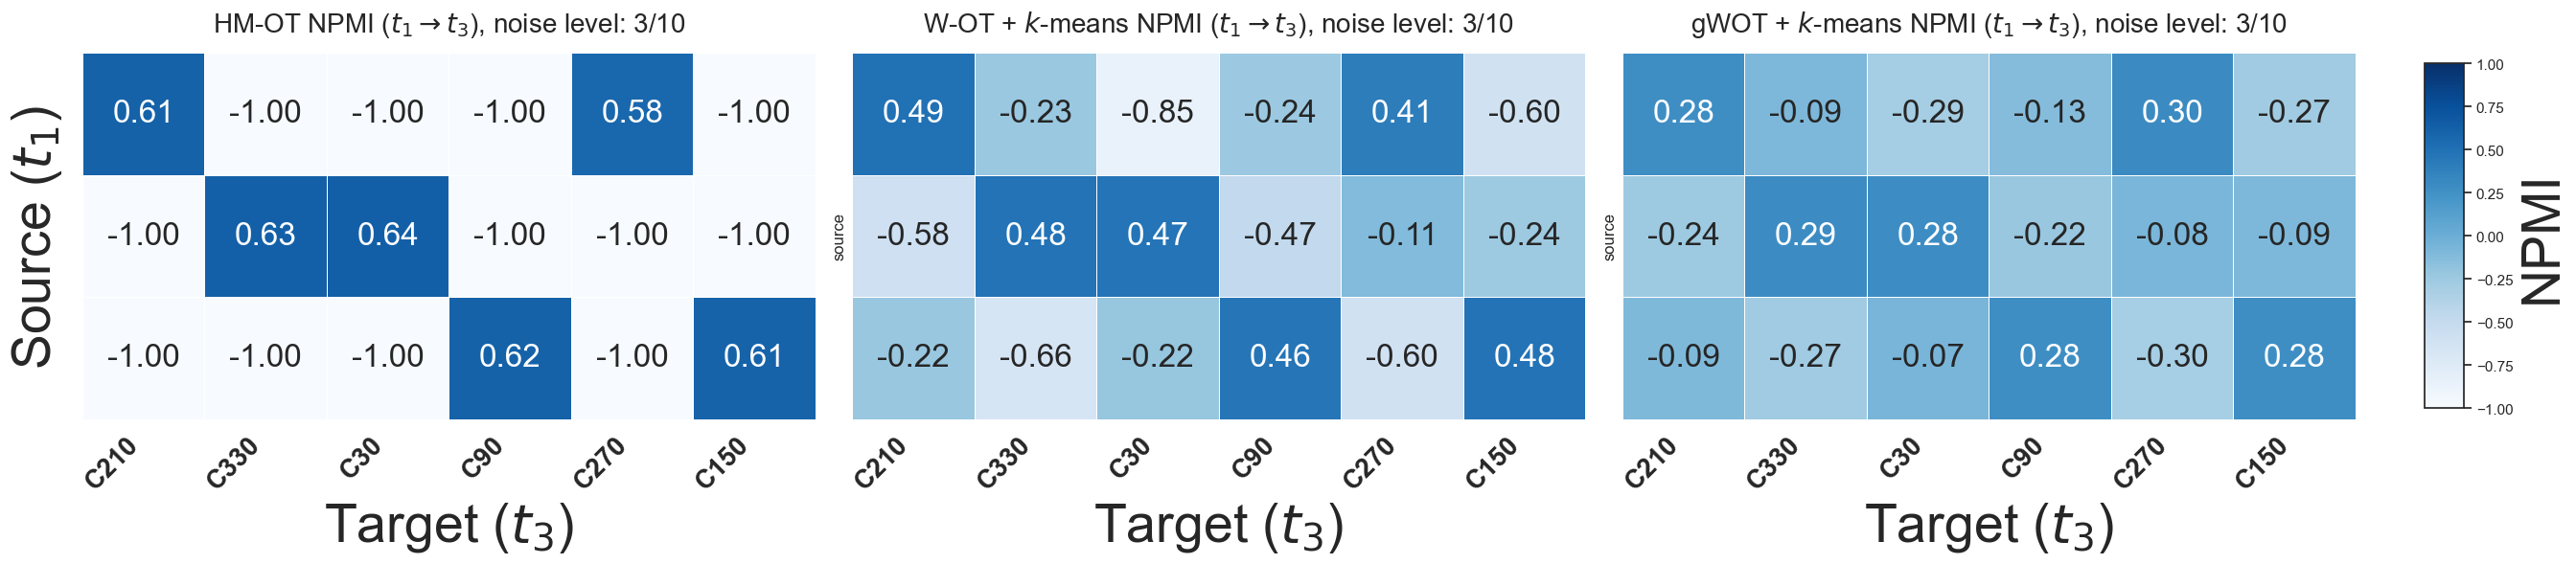

noise level 2.5


/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_75470/1370114835.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


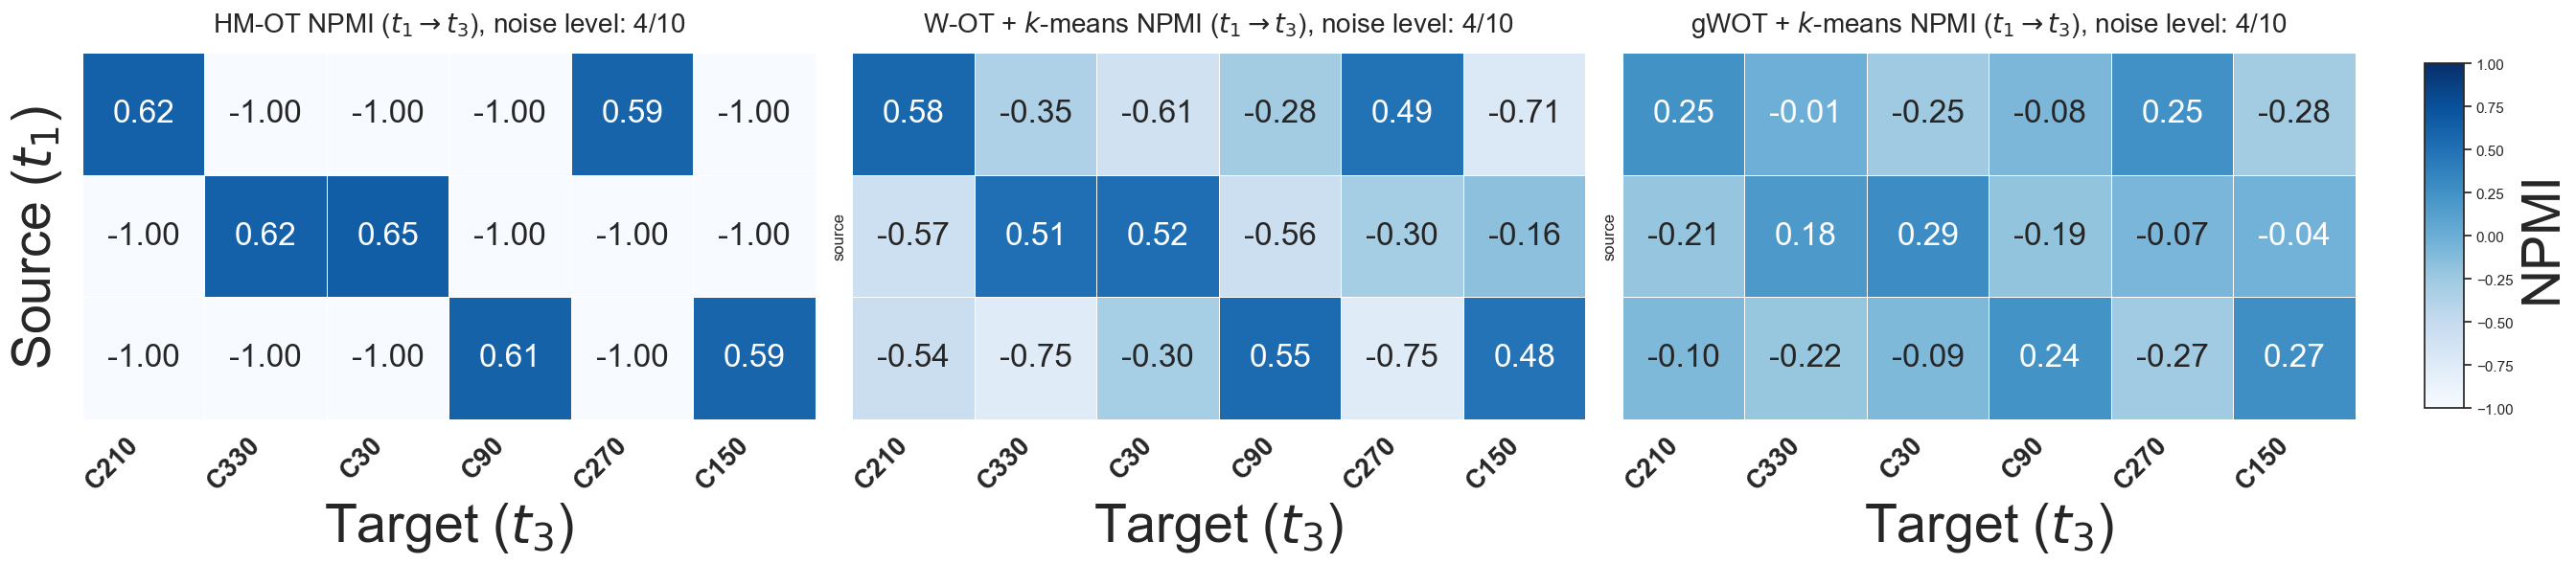

noise level 2.6666666666666665


/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_75470/1370114835.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


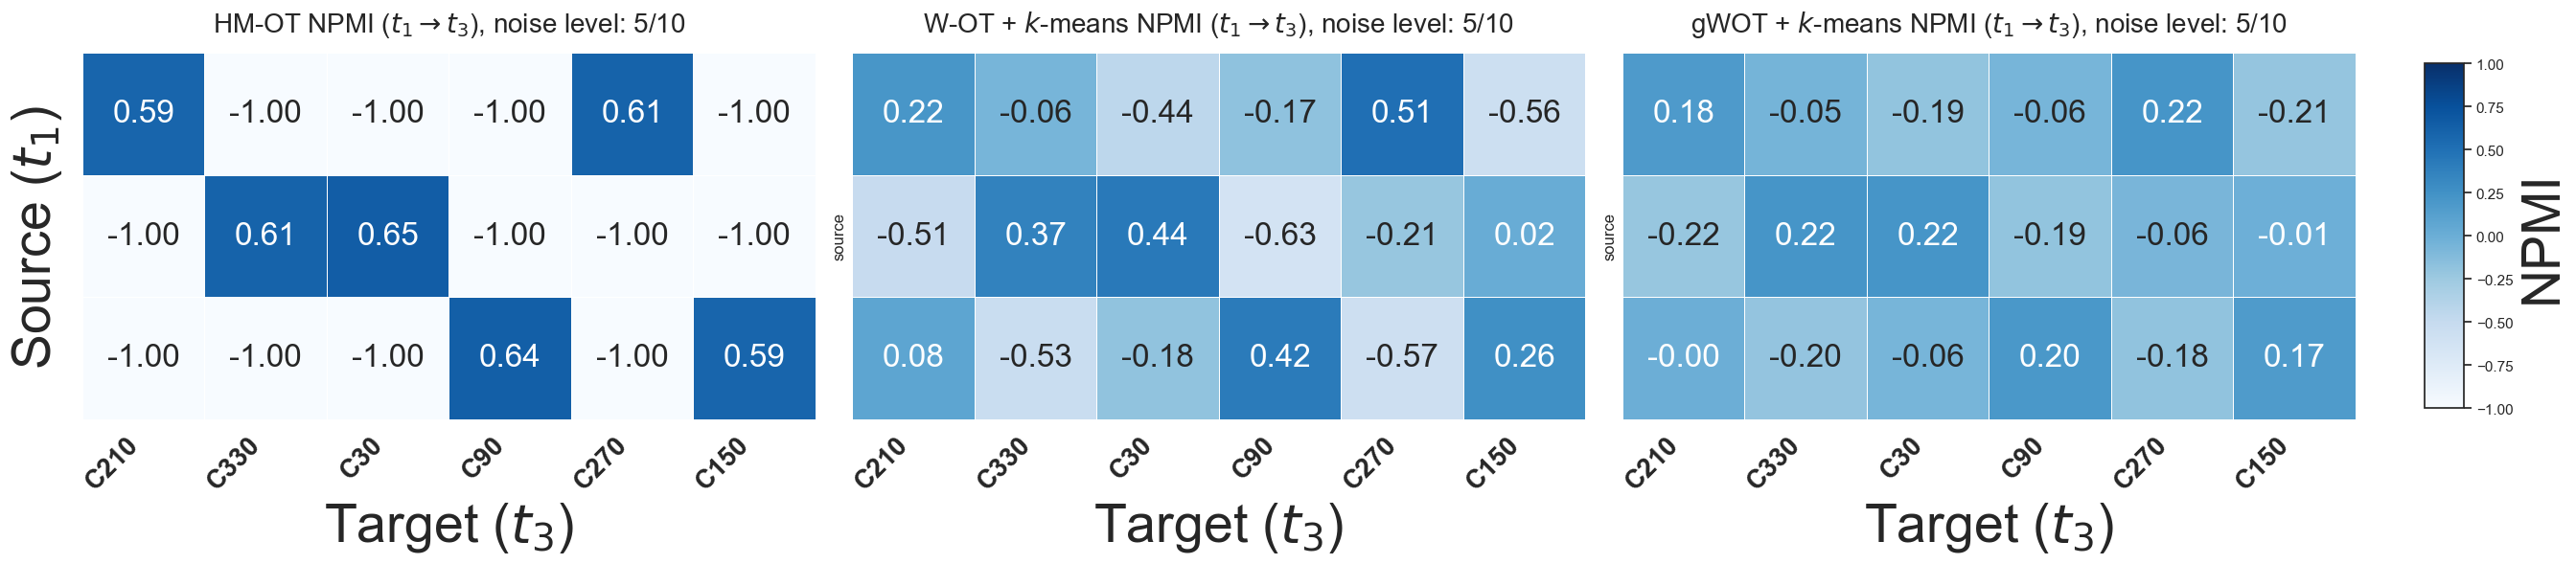

noise level 2.833333333333333


/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_75470/1370114835.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


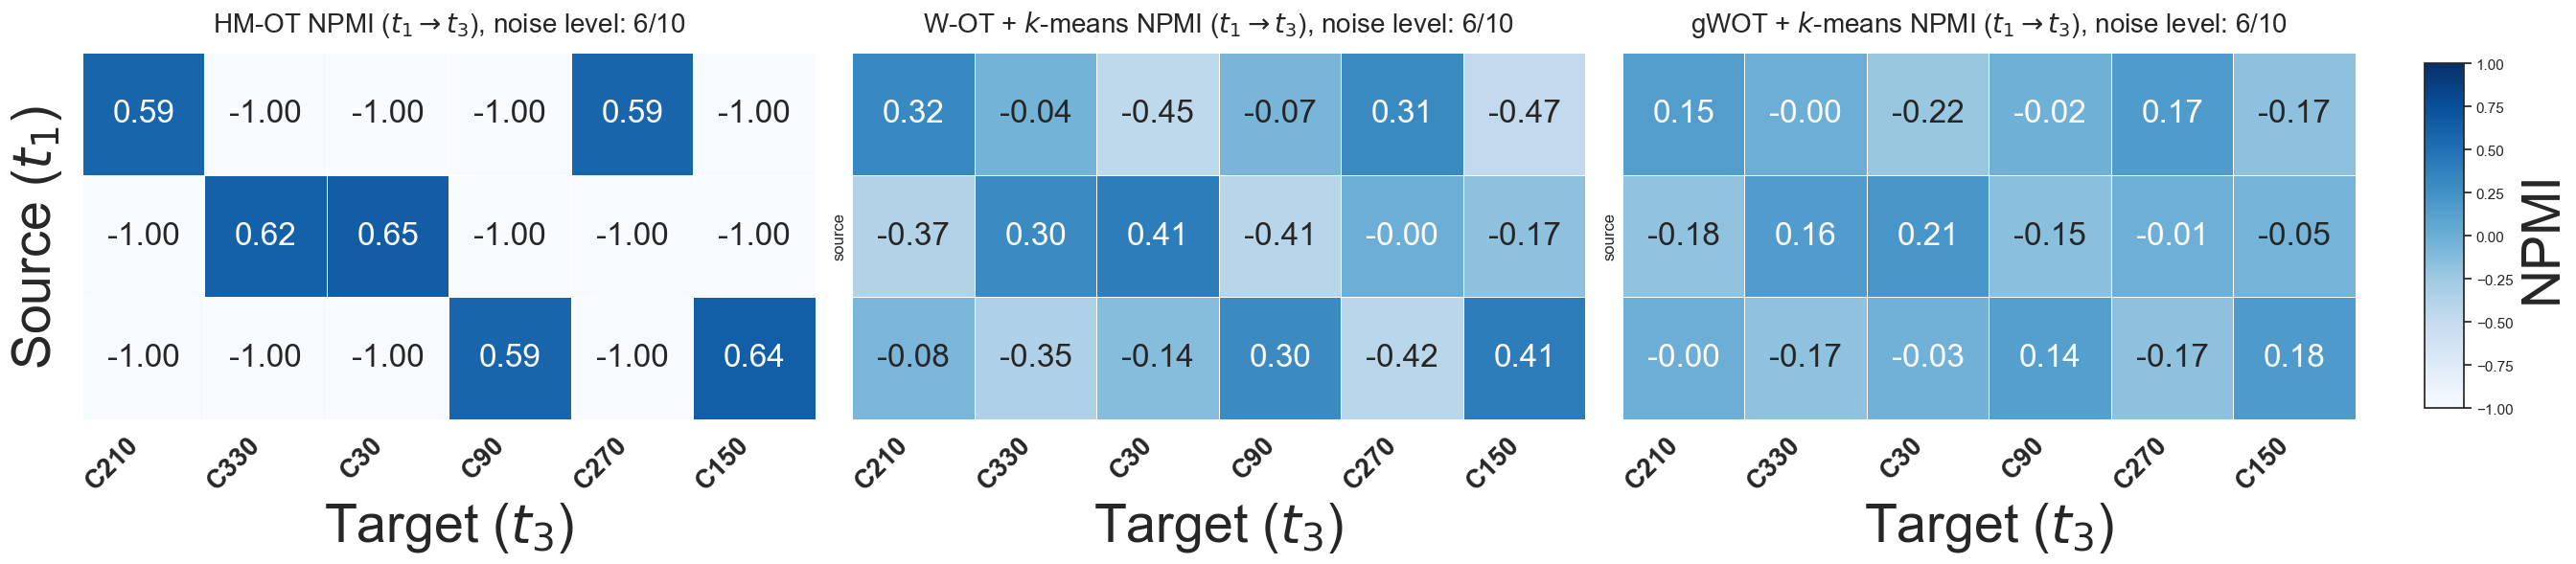

noise level 3.0


/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_75470/1370114835.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


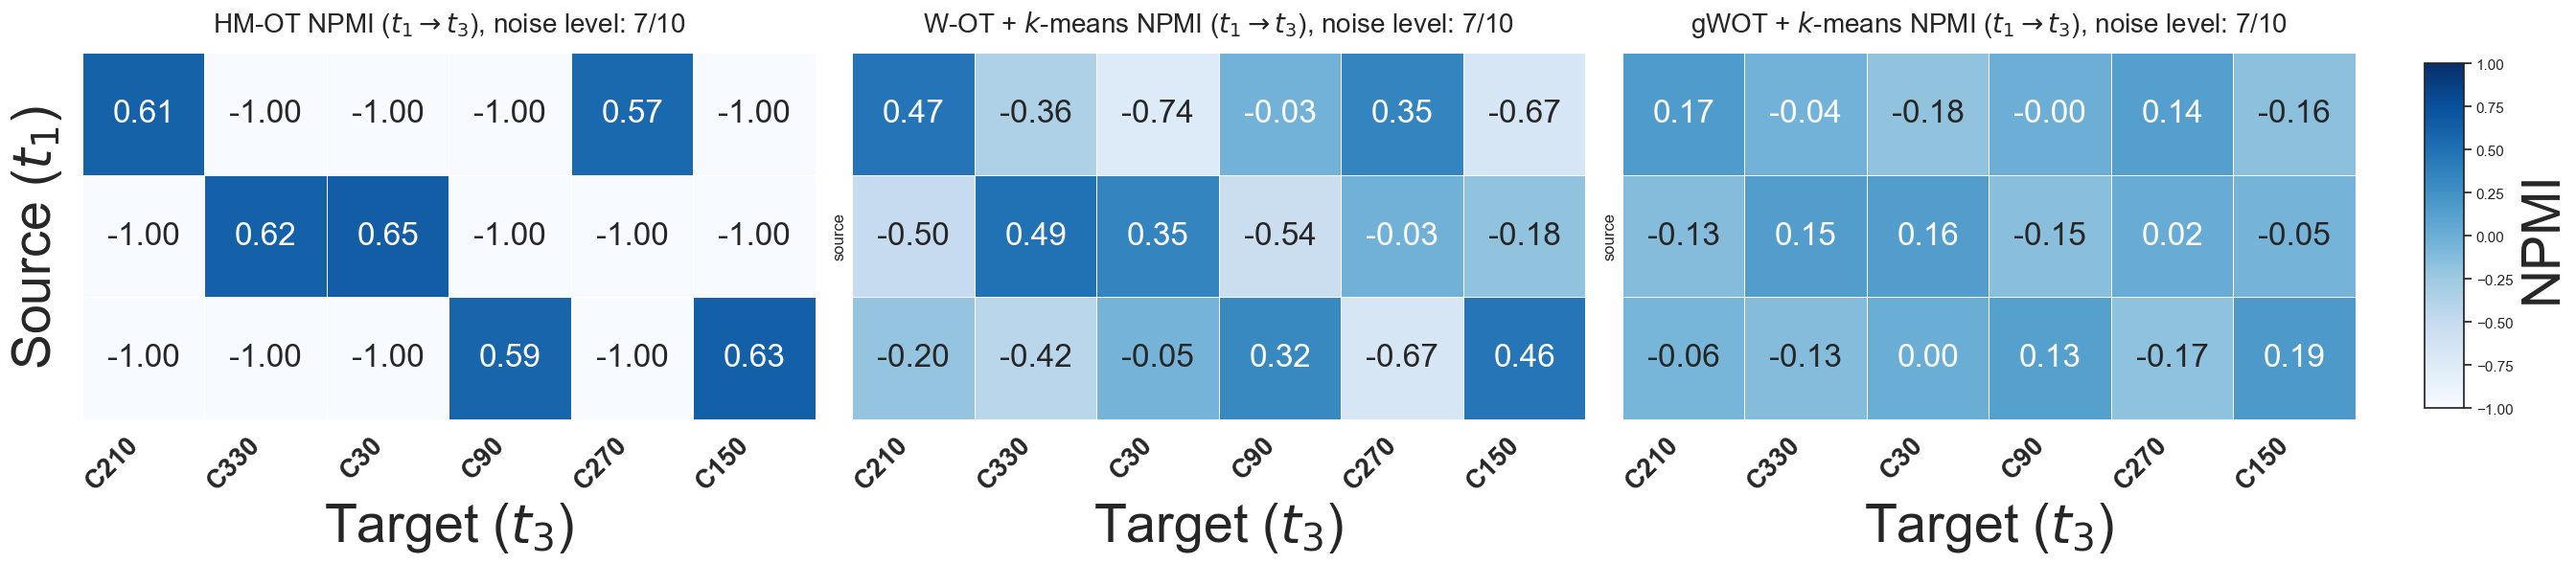

noise level 3.1666666666666665


/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_75470/1370114835.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


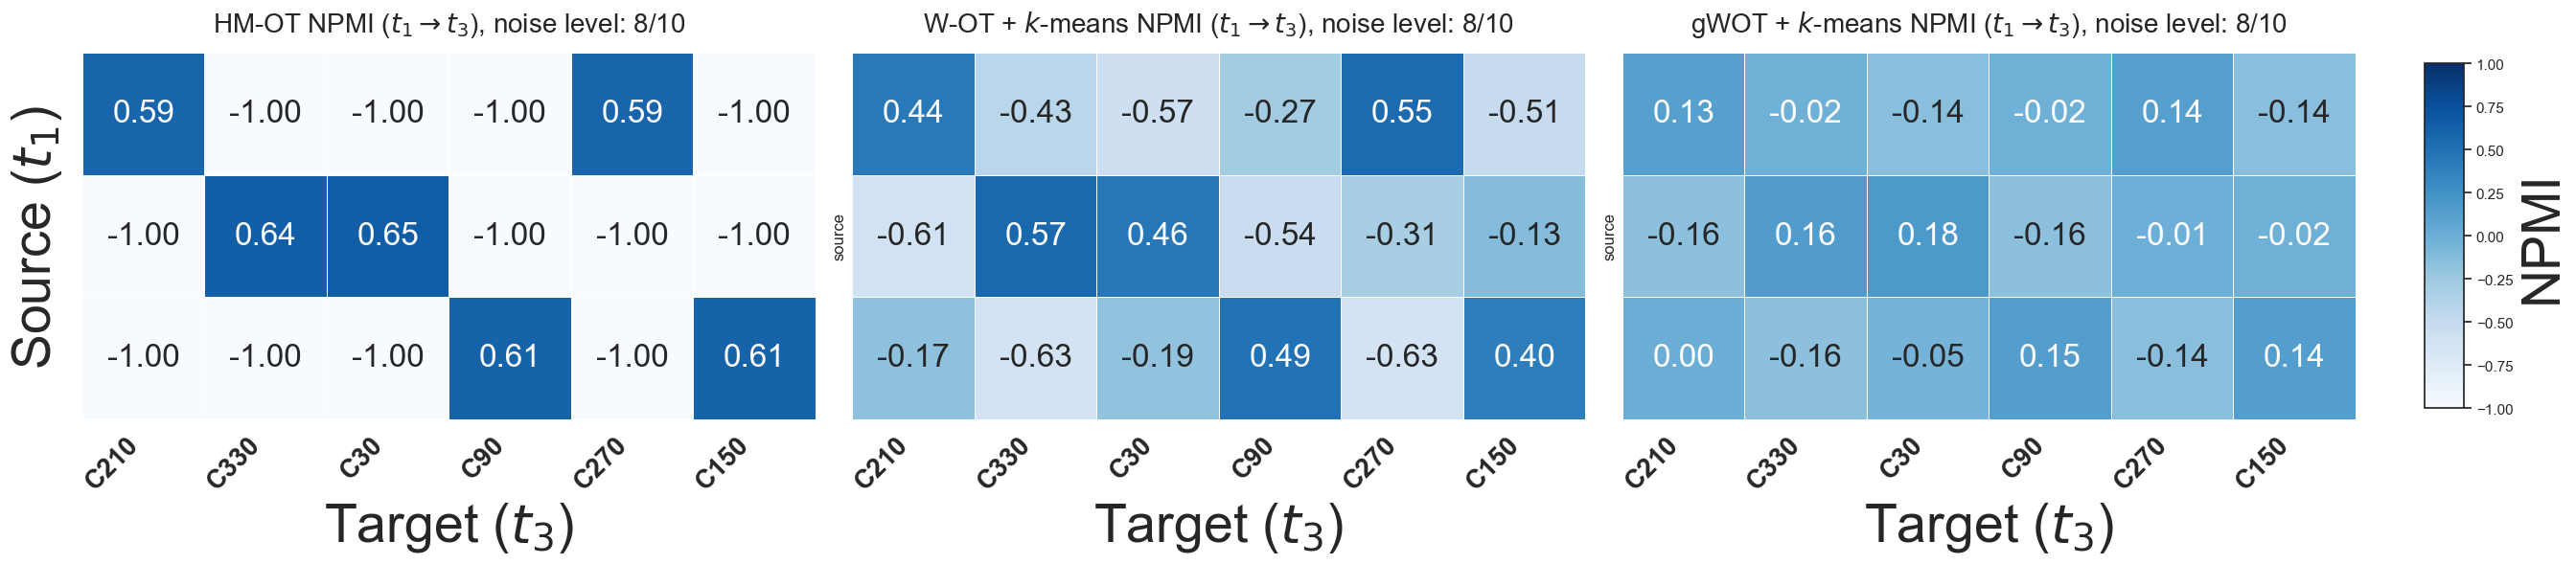

noise level 3.333333333333333


/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_75470/1370114835.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


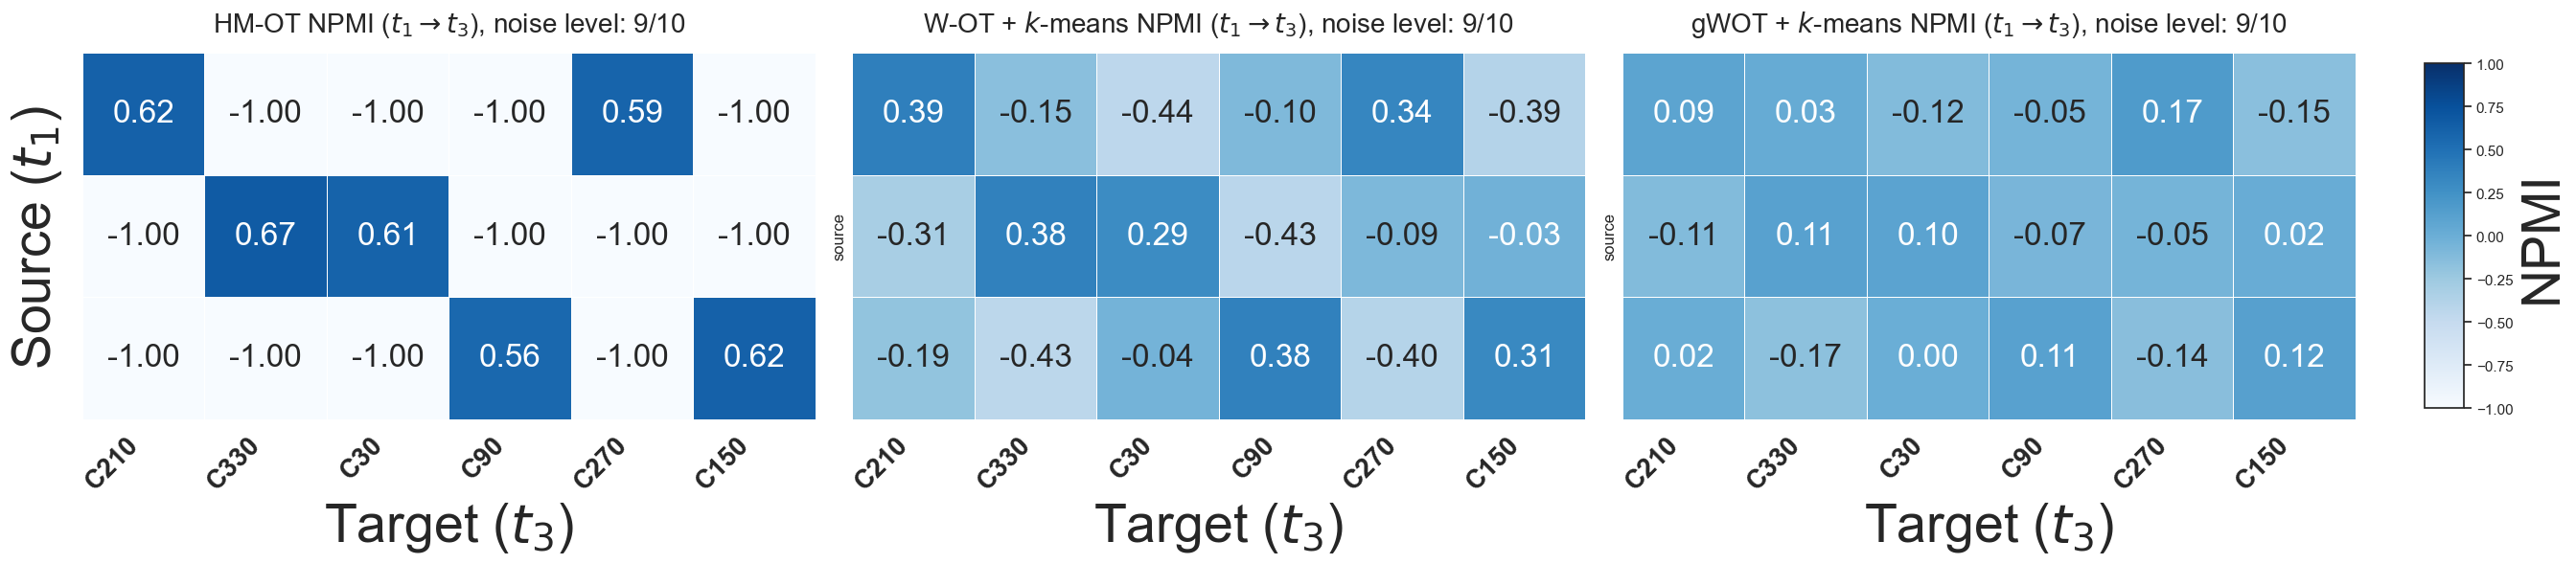

noise level 3.5


/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_75470/1370114835.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


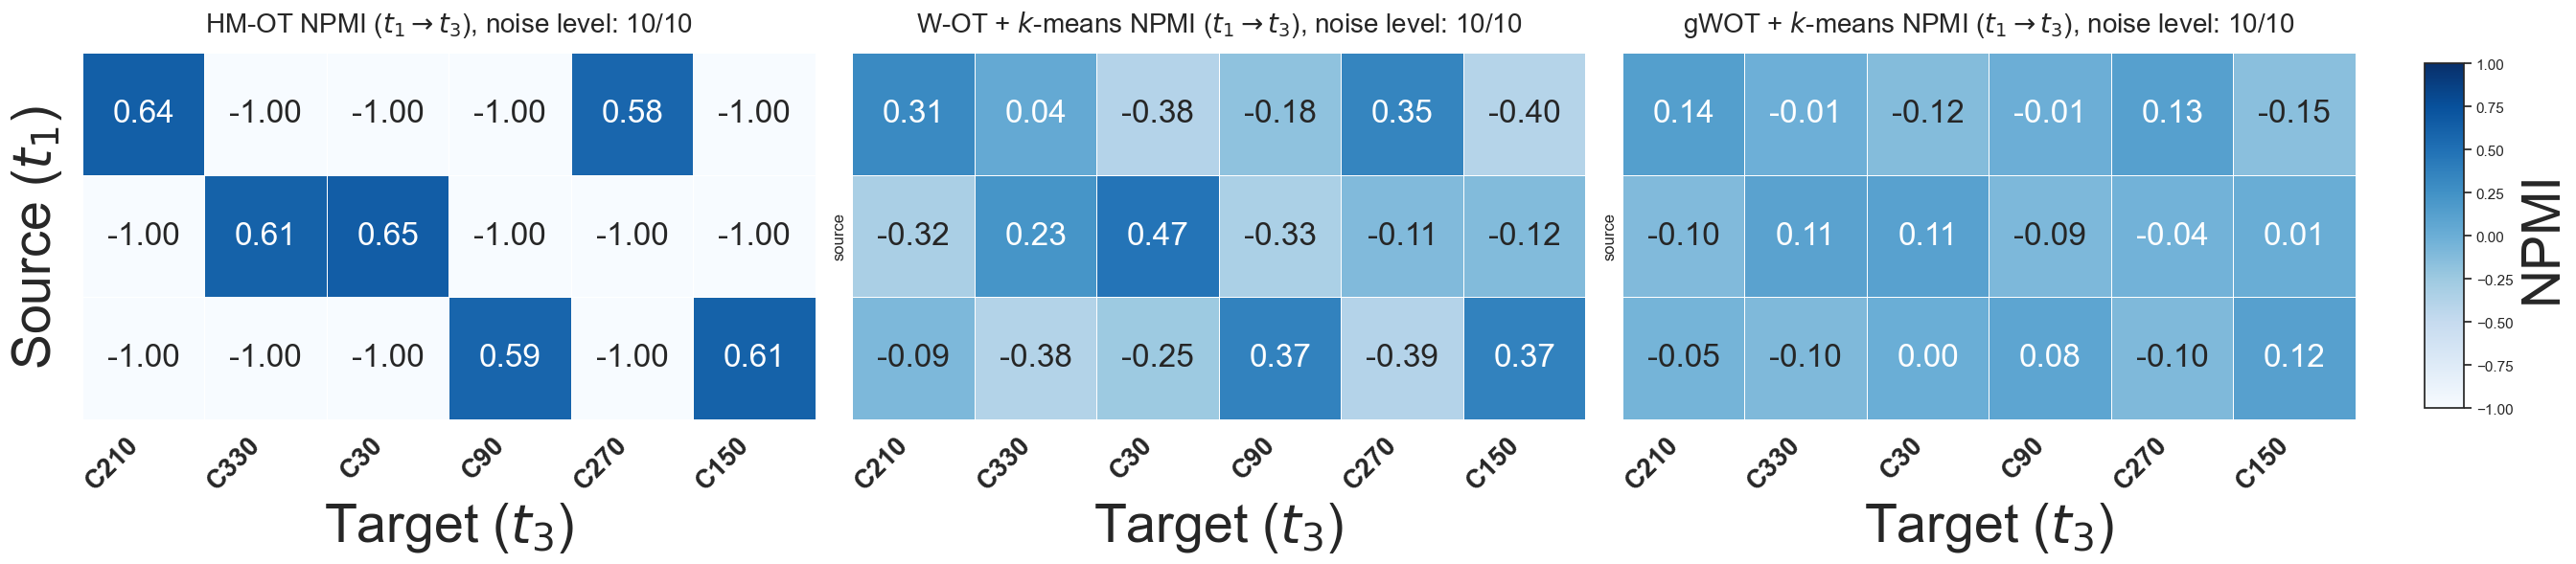

In [28]:
FONTSIZE=20

km_Qs_list_normalized = []
for i, level in enumerate(noise_level_range):
    print(f'noise level {i+1} / {len(noise_level_range)}: {level}')
    km_Qs_normalized = [ Q / Q.sum() for Q in km_Qs_list[i] ]
    km_Qs_list_normalized.append(km_Qs_normalized)

km_Qs_list_normalized[0][0].sum()

# Canonical and filtered order
canonical_order = ['A240', 'A0', 'A120', 'B210', 'B90', 'B330', 'B30', 'B270', 'B150', 
                   'C210', 'C330', 'C30', 'C90', 'C270', 'C150']

cmap = 'Blues' # 'mako', 'seismic_r' 

hmot_NPMI_matrix_list = []
wot_NPMI_matrix_list = []
gwot_NPMI_matrix_list = []

for ind, level in enumerate(noise_level_range):
    print(f'noise level {level}')

    # Compute NPMI matrix for HM-OT
    hmot_NPMI_df = NPMI_t1_to_t3_matrix(hmot_Qs_list[ind], hmot_Ts_list[ind], NPMI_VALLEYS_LIST)
    hmot_npmi_matrix_ = hmot_NPMI_df.pivot(index="source", columns="target", values="npmi")
    # Compute NPMI matrix for W-OT
    wot_NPMI_df = NPMI_t1_to_t3_matrix(km_Qs_list_normalized[ind], wot_Ts_list[ind], NPMI_VALLEYS_LIST)
    wot_npmi_matrix_ = wot_NPMI_df.pivot(index="source", columns="target", values="npmi")
    # Compute NPMI matrix for gWOT
    gwot_NPMI_df = NPMI_t1_to_t3_matrix(km_Qs_list_normalized[ind], gwot_Ts_list[ind], NPMI_VALLEYS_LIST)
    gwot_npmi_matrix_ = gwot_NPMI_df.pivot(index="source", columns="target", values="npmi")

    # Sort and restrict to valleys in canonical order
    row_labels = [l for l in canonical_order if l in NPMI_VALLEYS_LIST[0]]
    col_labels = [l for l in canonical_order if l in NPMI_VALLEYS_LIST[2]]

    # Sort and restrict to valleys in canonical order
    hmot_npmi_matrix = hmot_npmi_matrix_.reindex(index=row_labels, columns=col_labels)
    wot_npmi_matrix = wot_npmi_matrix_.reindex(index=row_labels, columns=col_labels)
    gwot_npmi_matrix = gwot_npmi_matrix_.reindex(index=row_labels, columns=col_labels)

    hmot_npmi_matrix = hmot_npmi_matrix.fillna(-1)
    wot_npmi_matrix = wot_npmi_matrix.fillna(-1)
    gwot_npmi_matrix = gwot_npmi_matrix.fillna(-1)

    # Append to lists for later use
    hmot_NPMI_matrix_list.append(hmot_npmi_matrix)
    wot_NPMI_matrix_list.append(wot_npmi_matrix)

    # Determine global min/max across both matrices for shared color scale
    vmin = -1.0 # min(hmot_npmi_matrix.min().min(), wot_npmi_matrix.min().min())
    vmax = 1.0 # max(hmot_npmi_matrix.max().max(), wot_npmi_matrix.max().max())

    sns.set_theme(style="white", context="notebook")

    # --- PLOT 3 SIDE BY SIDE ---
    fig, axes = plt.subplots(1, 3, figsize=(27, 9), sharey=True)

    mats = [
        ("HM-OT NPMI ($t_1\\to t_3$)", hmot_npmi_matrix),
        ("W-OT + $k$-means NPMI ($t_1\\to t_3$)", wot_npmi_matrix),
        ("gWOT + $k$-means NPMI ($t_1\\to t_3$)", gwot_npmi_matrix),
    ]

    heatmaps = []
    for k, (title, mat) in enumerate(mats):
        hm = sns.heatmap(
            mat,
            annot=True,
            fmt=".2f",
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            linewidths=0.5,
            linecolor='white',
            square=True,
            ax=axes[k],
            cbar=False,  # add only once later
            annot_kws={"size": 24}
        )
        axes[k].set_title(f"{title}, noise level: {ind+1}/{len(noise_level_range)}",
                          fontsize=FONTSIZE, pad=16)
        axes[k].set_xlabel("Target ($t_3$)", fontsize=2*FONTSIZE)
        axes[k].set_xticklabels(axes[k].get_xticklabels(), rotation=45,
                                ha="right", fontsize=FONTSIZE, weight='bold')
        if k == 0:
            axes[k].set_ylabel("Source ($t_1$)", fontsize=2*FONTSIZE)
            axes[k].set_yticklabels(axes[k].get_yticklabels(), rotation=0,
                                    fontsize=FONTSIZE, weight='bold')
        else:
            axes[k].set_yticklabels([])

        heatmaps.append(hm)

    # Shared colorbar on the right
    cbar_ax = fig.add_axes([0.94, 0.3, 0.015, 0.4])
    cb = fig.colorbar(heatmaps[-1].collections[0], cax=cbar_ax)
    cb.set_label("NPMI", fontsize=2*FONTSIZE)

    plt.tight_layout(rect=[0, 0, 0.92, 1])
    plt.show()

## Frobenius norm to ground-truth diffmap plots

### Frobenius norm $t_1 \to t_2$

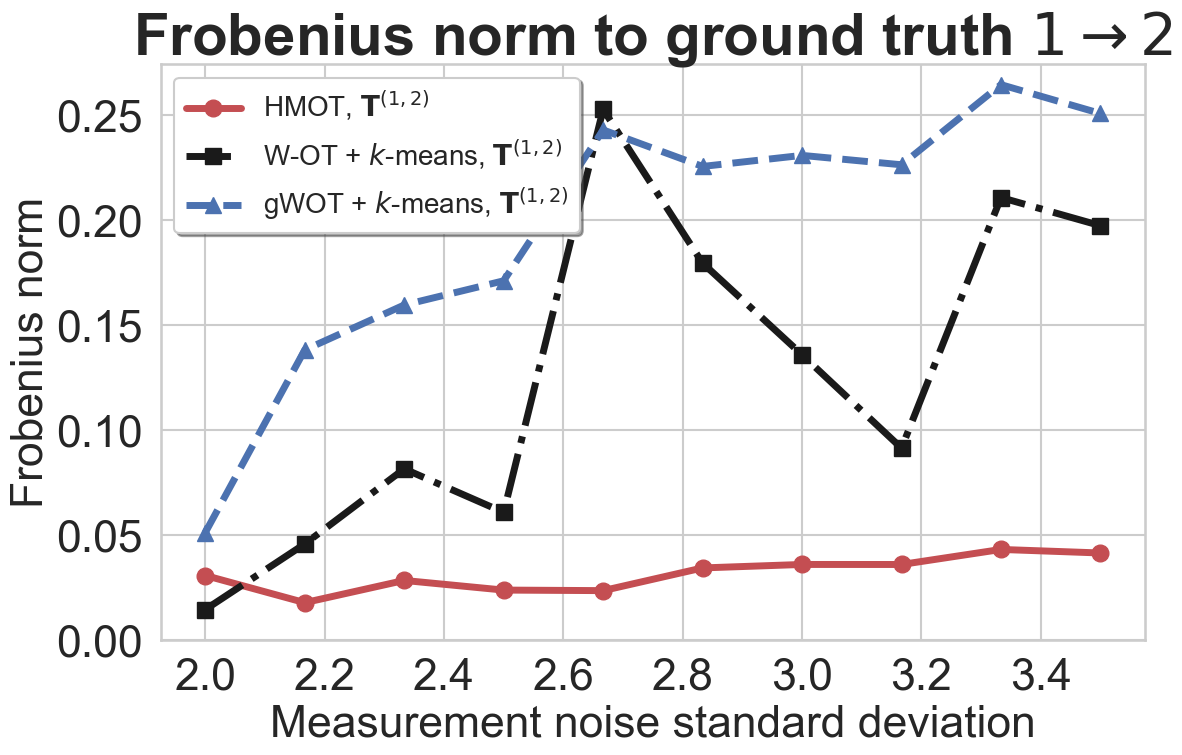

In [20]:
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

plt.figure(figsize=(12, 8))

hmot_Frob_12_np = np.array(hmot_Frob_12_list)
wot_Frob_12_np = np.array(wot_Frob_12_list)

y_max = max(np.max(hmot_Frob_12_np), np.max(wot_Frob_12_np), np.max(gwot_Frob_12_list))

plt.plot(noise_level_range,
         hmot_Frob_12_np,
         'r-',
         linewidth=5,
         label='HMOT, $\mathbf{T}^{(1,2)}$',
         marker='o',
         markersize=12,
         alpha=1.0)

plt.plot(noise_level_range,
         wot_Frob_12_np,
         'k-.',
         linewidth=5,
         label='W-OT + $k$-means, $\mathbf{T}^{(1,2)}$',
         marker='s',
         markersize=12,
         alpha=1.0)

plt.plot(noise_level_range,
         gwot_Frob_12_list,
         'b--',
         linewidth=5,
         label='gWOT + $k$-means, $\mathbf{T}^{(1,2)}$',
         marker='^',
         markersize=12,
         alpha=1.0)

plt.xlabel(f'Measurement noise standard deviation', fontsize=32)
plt.ylabel('Frobenius norm', fontsize=32)
plt.title(f'Frobenius norm to ground truth $1 \\to 2$', fontsize=42, fontweight='bold')

plt.legend(fontsize=20, frameon=True, fancybox=True, shadow=True)

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
eps = 1e-2
plt.ylim(0, y_max + eps)

plt.tight_layout()
plt.show()

### Frobenius norm $t_2 \to t_3$

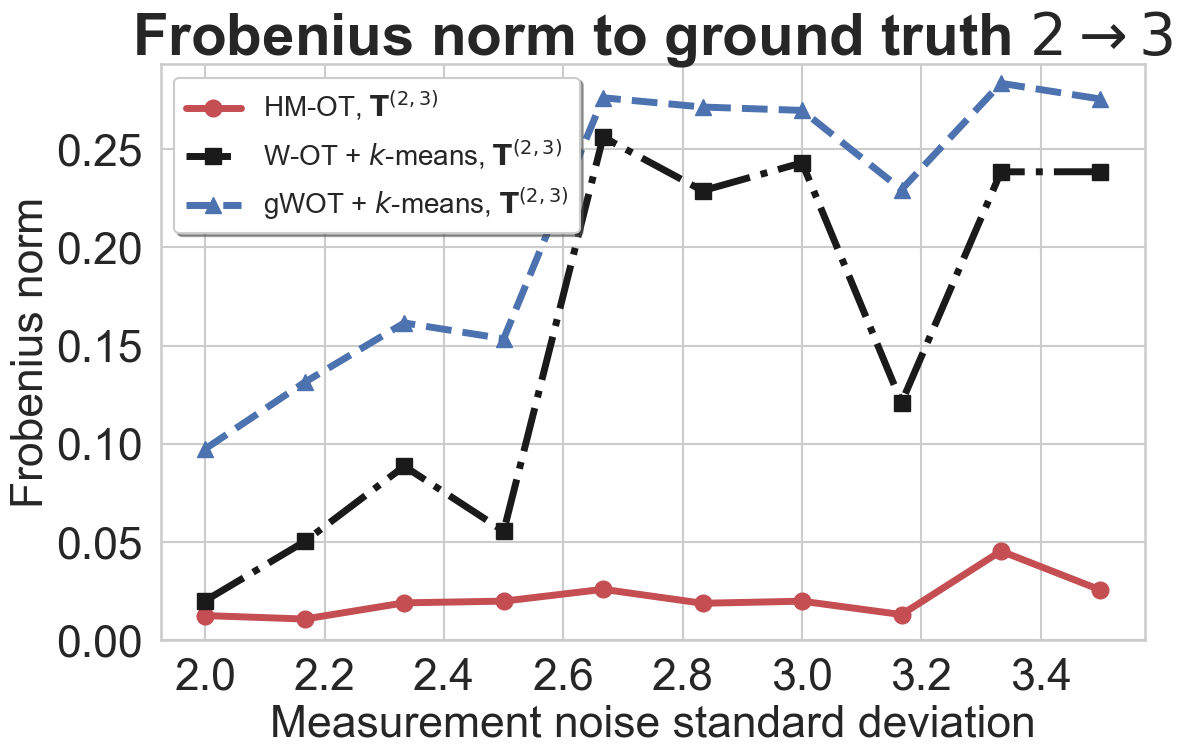

In [21]:
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

plt.figure(figsize=(12, 8))

hmot_Frob_23_np = np.array(hmot_Frob_23_list)
wot_Frob_23_np = np.array(wot_Frob_23_list)

y_max = max(np.max(hmot_Frob_23_np), np.max(wot_Frob_23_np), np.max(gwot_Frob_23_list))

plt.plot(noise_level_range,
         hmot_Frob_23_np,
         'r-',
         linewidth=5,
         label='HM-OT, $\mathbf{T}^{(2,3)}$',
         marker='o',
         markersize=12,
         alpha=1.0)

plt.plot(noise_level_range,
         wot_Frob_23_np,
         'k-.',
         linewidth=5,
         label='W-OT + $k$-means, $\mathbf{T}^{(2,3)}$',
         marker='s',
         markersize=12,
         alpha=1.0)

plt.plot(noise_level_range,
         gwot_Frob_23_list,
         'b--',
         linewidth=5,
         label='gWOT + $k$-means, $\mathbf{T}^{(2,3)}$',
         marker='^',
         markersize=12,
         alpha=1.0)

plt.xlabel(f'Measurement noise standard deviation', fontsize=32)
plt.ylabel('Frobenius norm', fontsize=32)
plt.title(f'Frobenius norm to ground truth $2 \\to 3$', fontsize=42, fontweight='bold')

plt.legend(fontsize=20, frameon=True, fancybox=True, shadow=True)

plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
eps = 1e-2
plt.ylim(0, y_max + eps)

plt.tight_layout()
plt.show()

## Centroid distances plots

### compute distances at each timepoint

In [22]:
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import numpy as np

def centroid_distance(gt_bary, pred_bary, *, average=True):
    """
    Match every predicted centroid to a ground-truth centroid with the
    Hungarian algorithm and return the (average) matching cost.

    Parameters
    ----------
    gt_bary, pred_bary : (k, d) float arrays
        Coordinates of ground-truth and predicted centroids.
    average : bool, default True
        If True, return the cost per centroid; otherwise return the sum.

    Returns
    -------
    cost : float
        Optimal transport cost between the two centroid sets.
    """
    # 1. Pairwise distances
    C = cdist(gt_bary, pred_bary, metric="euclidean")
    C = C ** 2

    # 2. Optimal assignment
    row_idx, col_idx = linear_sum_assignment(C)

    # 3. Cost of that assignment
    cost = C[row_idx, col_idx].sum()
    return cost / len(row_idx) if average else cost

gt_barys = [get_barycenters(Q, S) for Q, S in zip(Qs_gt_reduced, [S[GOOD_ROWS,:] for S in Ss])]

hmot_centroid_distances_list, km_centroid_distances_list = [], []

for i, level in enumerate(noise_level_range):

    hmot_centroid_distances, km_centroid_distances = [], []

    for t in range(3):
        gt_bary  = gt_barys[t]
        hmot_bary = hmot_noisy_bary_list[i][t]
        km_bary   =  km_noisy_bary_list[i][t]

        # Optimal (Hungarian) matching cost
        hmot_cost = centroid_distance(gt_bary, hmot_bary)   # average cost
        km_cost   = centroid_distance(gt_bary, km_bary)

        hmot_centroid_distances.append(hmot_cost)
        km_centroid_distances.append(km_cost)

    hmot_centroid_distances_list.append(hmot_centroid_distances)
    km_centroid_distances_list.append(km_centroid_distances)

hmot_centroid_distances_np = np.asarray(hmot_centroid_distances_list)
km_centroid_distances_np   = np.asarray(km_centroid_distances_list)

### centroid distances, $t=2$

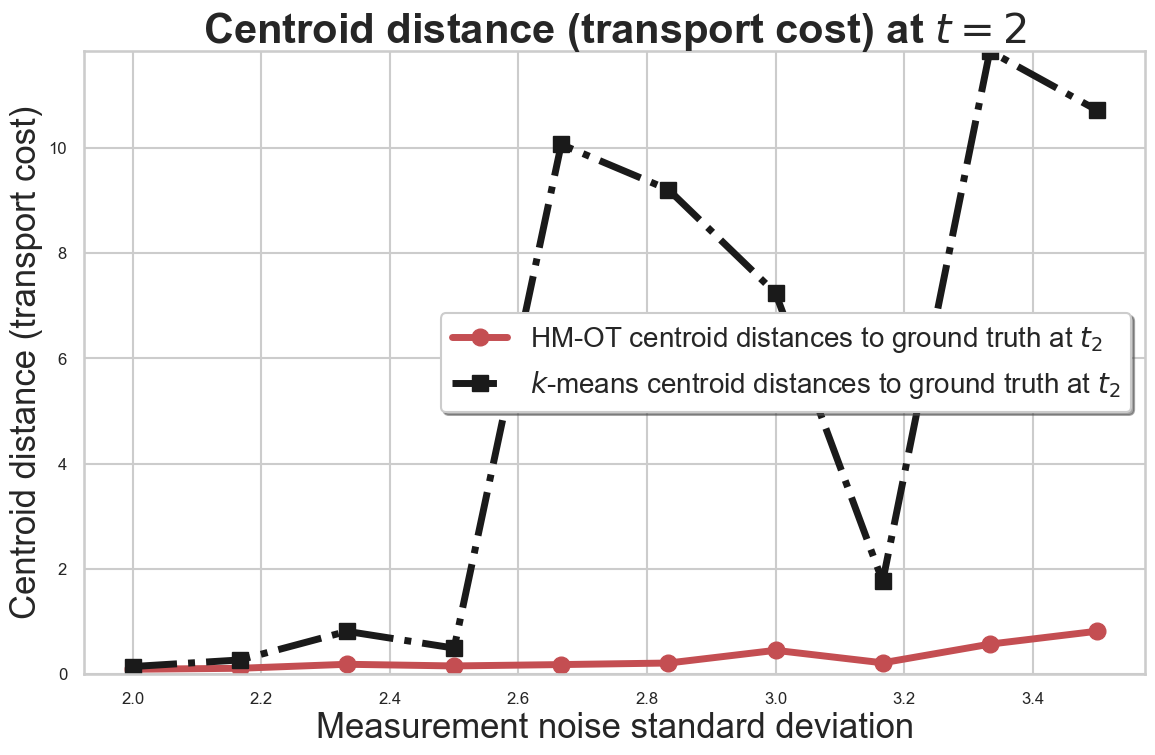

In [23]:
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

plt.figure(figsize=(12, 8))

hmot_centroid_distances_2 = hmot_centroid_distances_np[:, 1]
km_centroid_distances_2 = km_centroid_distances_np[:, 1]

y_max = max(np.max(hmot_centroid_distances_2), np.max(km_centroid_distances_2))

plt.plot(noise_level_range,
         hmot_centroid_distances_2,
         'r-',
         linewidth=5,
         label='HM-OT centroid distances to ground truth at $t_2$',
         marker='o',
         markersize=12,
         alpha=1.0)

plt.plot(noise_level_range,
         km_centroid_distances_2,
         'k-.',
         linewidth=5,
         label='$k$-means centroid distances to ground truth at $t_2$',
         marker='s',
         markersize=12,
         alpha=1.0)

plt.xlabel(f'Measurement noise standard deviation', fontsize=25)
plt.ylabel('Centroid distance (transport cost)', fontsize=25)
plt.title(f'Centroid distance (transport cost) at $t=2$', fontsize=30, fontweight='bold')

plt.legend(fontsize=20, frameon=True, fancybox=True, shadow=True)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, y_max)

plt.tight_layout()
plt.show()

### centroid distances, all timepoints

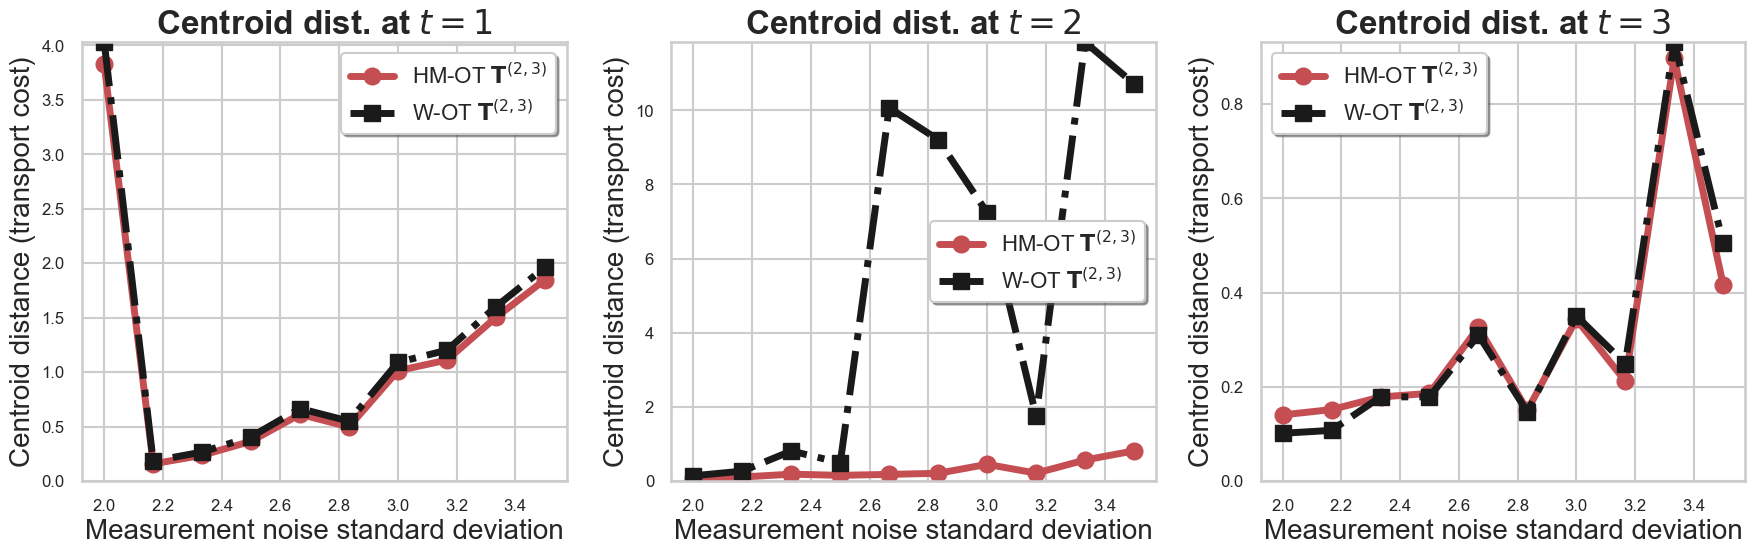

In [24]:
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through each column (assuming 3 columns)
for i in range(3):
    hmot_centroid_distances_i = hmot_centroid_distances_np[:, i]
    km_centroid_distances_i = km_centroid_distances_np[:, i]
    y_max = max(np.max(hmot_centroid_distances_i), np.max(km_centroid_distances_i))
    
    # Plot on the i-th subplot
    axes[i].plot(noise_level_range,
                 hmot_centroid_distances_i,
                 'r-',
                 linewidth=5,
                 label='HM-OT $\mathbf{T}^{(2,3)}$',
                 marker='o',
                 markersize=12,
                 alpha=1.0)
    
    axes[i].plot(noise_level_range,
                 km_centroid_distances_i,
                 'k-.',
                 linewidth=5,
                 label='W-OT $\mathbf{T}^{(2,3)}$',
                 marker='s',
                 markersize=12,
                 alpha=1.0)
    
    axes[i].set_xlabel('Measurement noise standard deviation', fontsize=20)
    axes[i].set_ylabel('Centroid distance (transport cost)', fontsize=20)
    axes[i].set_title(f'Centroid dist. at $t={i+1}$', fontsize=24, fontweight='bold')
    axes[i].legend(fontsize=16, frameon=True, fancybox=True, shadow=True)
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].set_ylim(0, y_max)

plt.tight_layout()
plt.show()

## Cosine similarity plots

In [25]:
t1_proportions = Ts_gt_reduced[0].sum(axis=1)
t2_proportions = Ts_gt_reduced[1].sum(axis=1) # not used to weight the cosine similarities
t3_proportions = Ts_gt_reduced[1].sum(axis=0)

hmot_diag_cossim_scores = []
wot_diag_cossim_scores = []
gwot_diag_cossim_scores = []

for ind, (hmot_cossim, wot_cossim, gwot_cossim) in enumerate(zip(hmot_cossim_list, wot_cossim_list, gwot_cossim_list)):
    t1_diag  = np.diag(t1_proportions)
    t3_diag  = np.diag(t3_proportions)
    print(f'noise level {ind+1} / {len(noise_level_range)}')
    # print('HM-OT centroid cosine similarities:', hmot_cossim)
    # print('W-OT centroid cosine similarities:', wot_cossim)
    t1_hmot_cossim = hmot_cossim[0]
    t1_wot_cossim  = wot_cossim[0]
    t1_gwot_cossim = gwot_cossim[0]

    t3_hmot_cossim = hmot_cossim[1]
    t3_wot_cossim  = wot_cossim[1]
    t3_gwot_cossim  = gwot_cossim[1]

    t1_hmot_score = np.sum(t1_diag * t1_hmot_cossim)
    t1_wot_score  = np.sum(t1_diag * t1_wot_cossim)
    t1_gwot_score = np.sum(t1_diag * t1_gwot_cossim)
    t3_hmot_score = np.sum(t3_diag * t3_hmot_cossim)
    t3_wot_score  = np.sum(t3_diag * t3_wot_cossim)
    t3_gwot_score = np.sum(t3_diag * t3_gwot_cossim)

    hmot_diag_cossim_scores.append((t1_hmot_score, t3_hmot_score))
    wot_diag_cossim_scores.append((t1_wot_score, t3_wot_score))
    gwot_diag_cossim_scores.append((t1_gwot_score, t3_gwot_score))

hmot_diag_cossim_np = np.array(hmot_diag_cossim_scores)
wot_diag_cossim_np = np.array(wot_diag_cossim_scores)
gwot_diag_cossim_np = np.array(gwot_diag_cossim_scores)

noise level 1 / 10
noise level 2 / 10
noise level 3 / 10
noise level 4 / 10
noise level 5 / 10
noise level 6 / 10
noise level 7 / 10
noise level 8 / 10
noise level 9 / 10
noise level 10 / 10


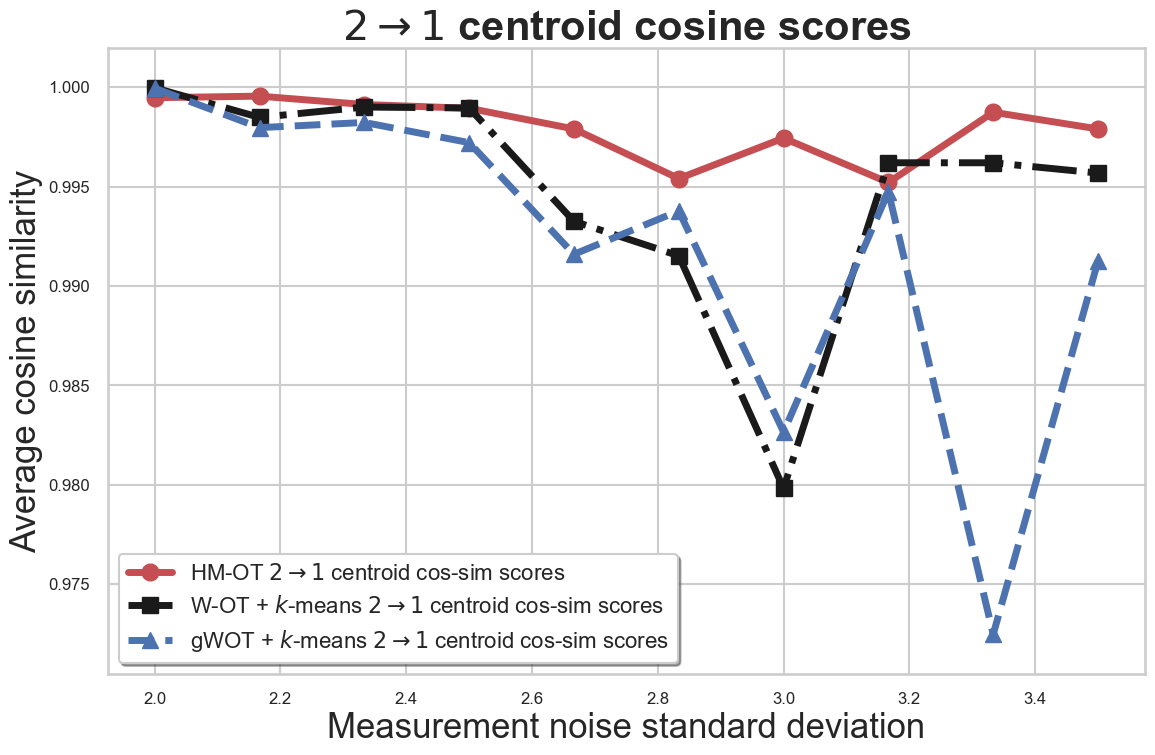

In [26]:
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

plt.figure(figsize=(12, 8))


y_max = max(np.max(hmot_diag_cossim_np), np.max(wot_diag_cossim_np), np.max(gwot_diag_cossim_np))
y_min = min(np.min(hmot_diag_cossim_np), np.min(wot_diag_cossim_np), np.min(gwot_diag_cossim_np))

plt.plot(noise_level_range,
         hmot_diag_cossim_np[:, 0],
         'r-',
         linewidth=5,
         label='HM-OT $2\\to1$ centroid cos-sim scores',
         marker='o',
         markersize=12,
         alpha=1.0)


plt.plot(noise_level_range,
         wot_diag_cossim_np[:, 0],
         'k-.',
         linewidth=5,
         label='W-OT + $k$-means $2\\to1$ centroid cos-sim scores',
         marker='s',
         markersize=12,
         alpha=1.0)

plt.plot(noise_level_range,
         gwot_diag_cossim_np[:, 0],
         'b--',
         linewidth=5,
         label='gWOT + $k$-means $2\\to1$ centroid cos-sim scores',
         marker='^',
         markersize=12,
         alpha=1.0)

plt.xlabel(f'Measurement noise standard deviation', fontsize=25)
plt.ylabel('Average cosine similarity', fontsize=25)
plt.title(f'$2\\to1$ centroid cosine scores', fontsize=30, fontweight='bold')

plt.legend(fontsize=16, frameon=True, fancybox=True, shadow=True)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt_eps = 2e-3
plt.ylim(y_min - plt_eps, y_max + plt_eps)

plt.tight_layout()
plt.show()

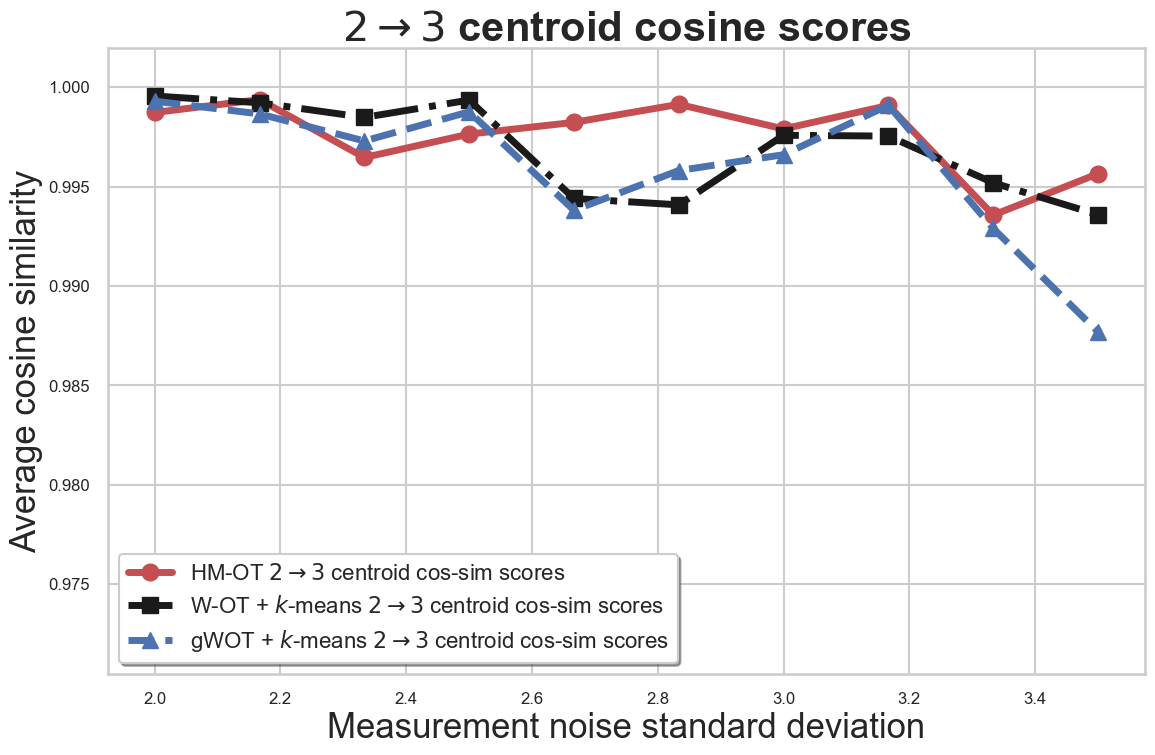

In [27]:
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)

plt.figure(figsize=(12, 8))


y_max = max(np.max(hmot_diag_cossim_np), np.max(wot_diag_cossim_np), np.max(gwot_diag_cossim_np))
y_min = min(np.min(hmot_diag_cossim_np), np.min(wot_diag_cossim_np), np.min(gwot_diag_cossim_np))

plt.plot(noise_level_range,
         hmot_diag_cossim_np[:, 1],
         'r-',
         linewidth=5,
         label='HM-OT $2\\to3$ centroid cos-sim scores',
         marker='o',
         markersize=12,
         alpha=1.0)


plt.plot(noise_level_range,
         wot_diag_cossim_np[:, 1],
         'k-.',
         linewidth=5,
         label='W-OT + $k$-means $2\\to3$ centroid cos-sim scores',
         marker='s',
         markersize=12,
         alpha=1.0)

plt.plot(noise_level_range,
         gwot_diag_cossim_np[:, 1],
         'b--',
         linewidth=5,
         label='gWOT + $k$-means $2\\to3$ centroid cos-sim scores',
         marker='^',
         markersize=12,
         alpha=1.0)


plt.xlabel(f'Measurement noise standard deviation', fontsize=25)
plt.ylabel('Average cosine similarity', fontsize=25)
plt.title(f'$2\\to3$ centroid cosine scores', fontsize=30, fontweight='bold')

plt.legend(fontsize=16, frameon=True, fancybox=True, shadow=True)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt_eps = 2e-3
plt.ylim(y_min - plt_eps, y_max + plt_eps)

plt.tight_layout()
plt.show()